# Classifying Public Institutions By Effectiveness

Using IPEDS data, I was able to train a linear regression model incorporating PCA.   I also was able to classify the schools into different categories using various clustering models.  I used selectivity variables, and institutional funding as the main predictive variables.  

- toc: true
- badges: true
- comments: true
- image: images/IPEDS.png

In [1]:
##Run these and then restart kernal
#!pip install graphviz
#!pip install matplotlib --upgrade
#!pip install scikit-learn --upgrade
#!pip install dtreeviz

In [1]:
##import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, accuracy_score, auc, roc_curve, explained_variance_score, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier

import random
%matplotlib inline

# set max columns to none
pd.set_option("display.max_columns", None)
 
# set colwidth hidher
pd.set_option('display.max_colwidth', 100)


##set seed for reproducibility
random.seed(21)

In [2]:
##read in continental us and remove unnecessary columns
ipeds = pd.read_csv("/dsa/groups/capstonesp2022/on-campus/group_2/IPEDSApril26_updated.csv")
ipeds = ipeds.drop(columns = ['Unnamed: 0'])
ipeds.head()

unitid    year   est_fte  exp_instruc_total_per  exp_acad_supp_total_per  \
0  100654.0  2005.0  0.090823               0.017790                 0.008844   
1  100654.0  2006.0  0.089841               0.019824                 0.009532   
2  100654.0  2007.0  0.083368               0.022740                 0.011179   
3  100654.0  2008.0  0.080223               0.022626                 0.010009   
4  100654.0  2009.0  0.079459               0.023176                 0.007307   

   exp_student_serv_total_per  exp_inst_supp_total_per  \
0                    0.029916                 0.029844   
1                    0.030221                 0.032811   
2                    0.035761                 0.036962   
3                    0.034068                 0.024525   
4                    0.037372                 0.037780   

   exp_acad_inst_student_total_per  act_composite_75_pctl  \
0                         0.025031               0.157895   
1                         0.026845               0.157895   
2                         0.030852               0.149123   
3                         0.024116               0.157895   
4                         0.029416               0.149123   

   act_composite_25_pctl  completion_rate_150pct  acceptance_rate  \
0               0.140187                0.330986         0.395262   
1               0.140187                0.327968         0.386814   
2               0.140187                0.320926         0.289306   
3               0.140187                0.282696         0.468386   
4               0.140187                0.326962         0.450185   

  cc_basic_2010 STATE  Grad_Rates_Two_Classes  Grad_Rates_Three_Classes  \
0  Not Provided    AL                       0                         0   
1  Not Provided    AL                       0                         0   
2  Not Provided    AL                       0                         0   
3  Not Provided    AL                       0                         0   
4  Not Provided    AL                       0                         0   

   Grad_Rates_Quartiles  OrgStructure_Independent  OrgStructure_MultiCampus  \
0                     0                         1                         0   
1                     0                         1                         0   
2                     0                         1                         0   
3                     0                         1                         0   
4                     0                         1                         0   

   OrgStructure_MultiOrg  Carnegie_Art_Music_Design  Carnegie_Associate  \
0                      0                          0                   0   
1                      0                          0                   0   
2                      0                          0                   0   
3                      0                          0                   0   
4                      0                          0                   0   

   Carnegie_Bachelors  Carnegie_Business_Management  Carnegie_Engineering  \
0                   0                             0                     0   
1                   0                             0                     0   
2                   0                             0                     0   
3                   0                             0                     0   
4                   0                             0                     0   

   Carnegie_Graduate_Professional  Carnegie_Missing  \
0                               0                 1   
1                               0                 1   
2                               0                 1   
3                               0                 1   
4                               0                 1   

   Carnegie_Other_Tech_Health  Carnegie_Research_Universities  \
0                           0                               0   
1                           0                               0   
2                    

In [3]:
##one hot encode states
ipeds = pd.get_dummies(ipeds, columns=["STATE"], prefix=["US"] )

In [4]:
##drop na rows and view shape
dropped = ipeds.dropna()
print(dropped.shape)
dropped.head()

(15648, 78)


unitid    year   est_fte  exp_instruc_total_per  exp_acad_supp_total_per  \
0  100654.0  2005.0  0.090823               0.017790                 0.008844   
1  100654.0  2006.0  0.089841               0.019824                 0.009532   
2  100654.0  2007.0  0.083368               0.022740                 0.011179   
3  100654.0  2008.0  0.080223               0.022626                 0.010009   
4  100654.0  2009.0  0.079459               0.023176                 0.007307   

   exp_student_serv_total_per  exp_inst_supp_total_per  \
0                    0.029916                 0.029844   
1                    0.030221                 0.032811   
2                    0.035761                 0.036962   
3                    0.034068                 0.024525   
4                    0.037372                 0.037780   

   exp_acad_inst_student_total_per  act_composite_75_pctl  \
0                         0.025031               0.157895   
1                         0.026845               0.157895   
2                         0.030852               0.149123   
3                         0.024116               0.157895   
4                         0.029416               0.149123   

   act_composite_25_pctl  completion_rate_150pct  acceptance_rate  \
0               0.140187                0.330986         0.395262   
1               0.140187                0.327968         0.386814   
2               0.140187                0.320926         0.289306   
3               0.140187                0.282696         0.468386   
4               0.140187                0.326962         0.450185   

  cc_basic_2010  Grad_Rates_Two_Classes  Grad_Rates_Three_Classes  \
0  Not Provided                       0                         0   
1  Not Provided                       0                         0   
2  Not Provided                       0                         0   
3  Not Provided                       0                         0   
4  Not Provided                       0                         0   

   Grad_Rates_Quartiles  OrgStructure_Independent  OrgStructure_MultiCampus  \
0                     0                         1                         0   
1                     0                         1                         0   
2                     0                         1                         0   
3                     0                         1                         0   
4                     0                         1                         0   

   OrgStructure_MultiOrg  Carnegie_Art_Music_Design  Carnegie_Associate  \
0                      0                          0                   0   
1                      0                          0                   0   
2                      0                          0                   0   
3                      0                          0                   0   
4                      0                          0                   0   

   Carnegie_Bachelors  Carnegie_Business_Management  Carnegie_Engineering  \
0                   0                             0                     0   
1                   0                             0                     0   
2                   0                             0                     0   
3                   0                             0                     0   
4                   0                             0                     0   

   Carnegie_Graduate_Professional  Carnegie_Missing  \
0                               0                 1   
1                               0                 1   
2                               0                 1   
3                               0                 1   
4                               0                 1   

   Carnegie_Other_Tech_Health  Carnegie_Research_Universities  \
0                           0                               0   
1                           0                               0   
2                           0                            

In [5]:
##set seed for reproducibility
##split into test and train
##split into train test/val
train, testVal = train_test_split(dropped, test_size=0.25, random_state = 21)
##split into test validation
test, validation = train_test_split(testVal, test_size = .5, random_state = 21)

In [6]:
print(train.shape)
print(test.shape)
print(validation.shape)

(11736, 78)
(1956, 78)
(1956, 78)


In [7]:
##create subset of just desired variables from test and train dropping non feature columns.
X_train = train.loc[:, ~dropped.columns.isin(['unitid', 'Grad_Rates_Two_Classes', 'exp_acad_inst_student_total_per','Grad_Rates_Three_Classes', 'Grad_Rates_Quartiles', 'completion_rate_150pct', 'year', 'cc_basic_2010'])]

X_test = test.loc[:, ~dropped.columns.isin(['unitid', 'Grad_Rates_Two_Classes', 'exp_acad_inst_student_total_per','Grad_Rates_Three_Classes', 'Grad_Rates_Quartiles', 'completion_rate_150pct', 'year', 'cc_basic_2010'])]

y_train = train.completion_rate_150pct

y_test = test.completion_rate_150pct

X_train.head(1)


est_fte  exp_instruc_total_per  exp_acad_supp_total_per  \
11618  0.804298               0.092503                 0.049112   

       exp_student_serv_total_per  exp_inst_supp_total_per  \
11618                     0.06432                 0.055147   

       act_composite_75_pctl  act_composite_25_pctl  acceptance_rate  \
11618               0.236842               0.224299          0.54551   

       OrgStructure_Independent  OrgStructure_MultiCampus  \
11618                         0                         1   

       OrgStructure_MultiOrg  Carnegie_Art_Music_Design  Carnegie_Associate  \
11618                      0                          0                   0   

       Carnegie_Bachelors  Carnegie_Business_Management  Carnegie_Engineering  \
11618                   0                             0                     0   

       Carnegie_Graduate_Professional  Carnegie_Missing  \
11618                               0                 0   

       Carnegie_Other_Tech_Health  Carnegie_Research_Universities  \
11618                           0                               1   

       Carnegie_Theological  Carnegie_Tribal_Colleges  US_AL  US_AR  US_AZ  \
11618                     0                         0      0      0      0   

       US_CA  US_CO  US_CT  US_DE  US_FL  US_GA  US_IA  US_ID  US_IL  US_IN  \
11618      0      0      0      0      0      0      0      0      0      0   

       US_KS  US_KY  US_LA  US_MA  US_MD  US_ME  US_MI  US_MN  US_MO  US_MS  \
11618      0      0      0      0      0      0      0      0      0      0   

       US_MT  US_NC  US_ND  US_NE  US_NH  US_NJ  US_NM  US_NV  US_NY  US_OH  \
11618      0      0      0      0      0      0      0      0      0      0   

       US_OK  US_OR  US_PA  US_RI  US_SC  US_SD  US_TN  US_TX  US_UT  US_VA  \
11618      0      0      1      0      0      0      0      0      0      0   

       US_VT  US_WA  US_WI  US_WV  US_WY  
11618      0      0      0      0      0

In [8]:
##check its ready to run wtih no value errors
print(np.all(np.isfinite(X_train)))
print(np.any(np.isnan(X_train)))

True
False


## Looking at Multicollinearity

In [11]:
#plot color scaled correlation matrix
corrMatrix=X_train.corr()
corrMatrix.style.background_gradient(cmap='coolwarm')

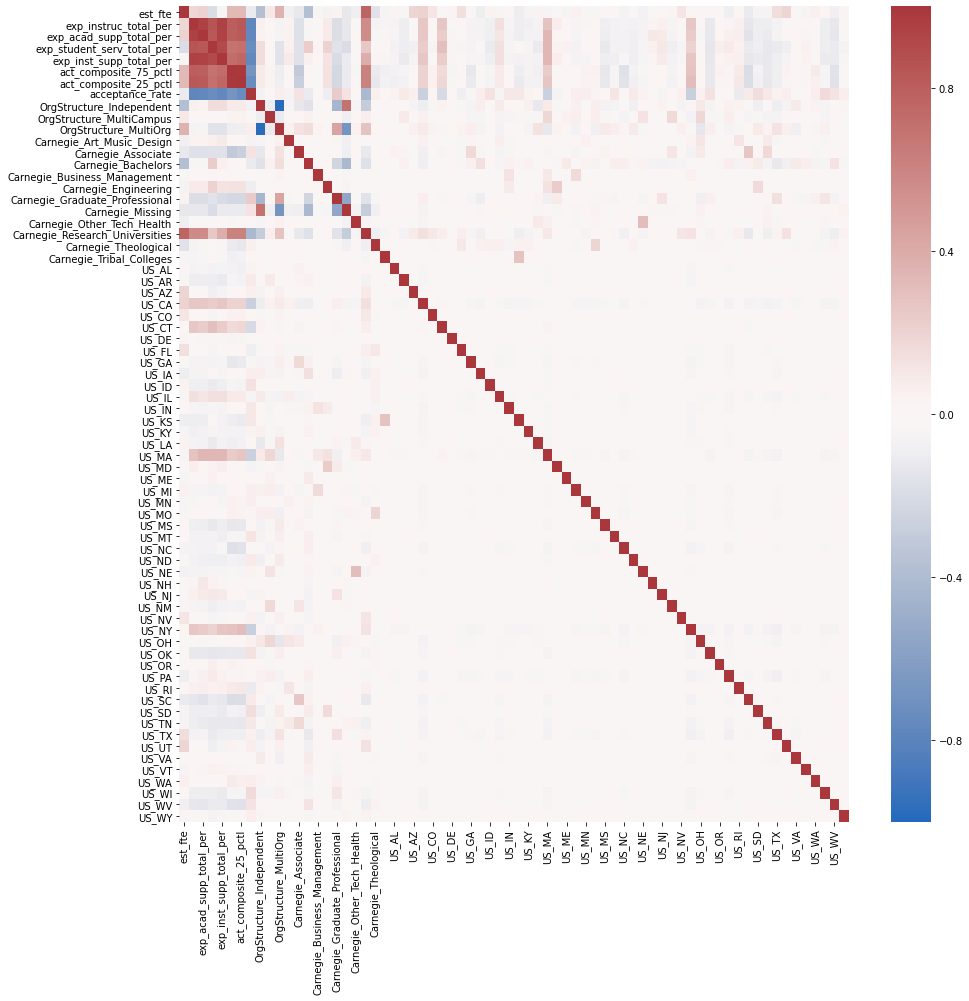

In [13]:
##Export a matrix for presentation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
matrix = corrMatrix.corr().round(2)
sns.heatmap(matrix, annot=False, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.savefig('CorrelationMatrix',dpi=300)

# Cross validation

In [12]:
##cross validation
scores = cross_val_score(LinearRegression(), X_train, y_train, cv = 10)
scores

array([0.73437544, 0.75058678, 0.73165224, 0.75366645, 0.60865991,
       0.76854665, 0.70585779, 0.44220904, 0.71482546, 0.72510093])

### Check for the most important parameters using random forest

In [14]:
##create subset of just desired variables from test and train
X_train = train.loc[:, ~dropped.columns.isin(['unitid', 'exp_acad_inst_student_total_per', 'Grad_Rates_Two_Classes', 'Grad_Rates_Three_Classes', 'Grad_Rates_Quartiles', 'completion_rate_150pct', 'year', 'cc_basic_2010'])]

X_test = test.loc[:, ~dropped.columns.isin(['unitid', 'exp_acad_inst_student_total_per', 'Grad_Rates_Two_Classes', 'Grad_Rates_Three_Classes', 'Grad_Rates_Quartiles', 'completion_rate_150pct', 'year', 'cc_basic_2010'])]

y_train = train.Grad_Rates_Two_Classes

y_test = test.Grad_Rates_Two_Classes

X_train.head(1)

est_fte  exp_instruc_total_per  exp_acad_supp_total_per  \
11618  0.804298               0.092503                 0.049112   

       exp_student_serv_total_per  exp_inst_supp_total_per  \
11618                     0.06432                 0.055147   

       act_composite_75_pctl  act_composite_25_pctl  acceptance_rate  \
11618               0.236842               0.224299          0.54551   

       OrgStructure_Independent  OrgStructure_MultiCampus  \
11618                         0                         1   

       OrgStructure_MultiOrg  Carnegie_Art_Music_Design  Carnegie_Associate  \
11618                      0                          0                   0   

       Carnegie_Bachelors  Carnegie_Business_Management  Carnegie_Engineering  \
11618                   0                             0                     0   

       Carnegie_Graduate_Professional  Carnegie_Missing  \
11618                               0                 0   

       Carnegie_Other_Tech_Health  Carnegie_Research_Universities  \
11618                           0                               1   

       Carnegie_Theological  Carnegie_Tribal_Colleges  US_AL  US_AR  US_AZ  \
11618                     0                         0      0      0      0   

       US_CA  US_CO  US_CT  US_DE  US_FL  US_GA  US_IA  US_ID  US_IL  US_IN  \
11618      0      0      0      0      0      0      0      0      0      0   

       US_KS  US_KY  US_LA  US_MA  US_MD  US_ME  US_MI  US_MN  US_MO  US_MS  \
11618      0      0      0      0      0      0      0      0      0      0   

       US_MT  US_NC  US_ND  US_NE  US_NH  US_NJ  US_NM  US_NV  US_NY  US_OH  \
11618      0      0      0      0      0      0      0      0      0      0   

       US_OK  US_OR  US_PA  US_RI  US_SC  US_SD  US_TN  US_TX  US_UT  US_VA  \
11618      0      0      1      0      0      0      0      0      0      0   

       US_VT  US_WA  US_WI  US_WV  US_WY  
11618      0      0      0      0      0

In [15]:

##anomoly detection and outlier removal
from sklearn.covariance import EllipticEnvelope
envelope1 = EllipticEnvelope(support_fraction=1, contamination=0.03).fit(X_train)

outliers1 = envelope1.predict(X_train)==-1  


X_clean1 = X_train[~outliers1]  
y_clean1 = y_train[~outliers1]

print(f"Num of outliers = {np.sum(outliers1)}")




/opt/conda/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Num of outliers = 353


In [16]:

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_clean1, y_clean1)

##grab importance values
importances = rf.feature_importances_

##sort the indices
sorted_indices = np.argsort(importances)[::-1]



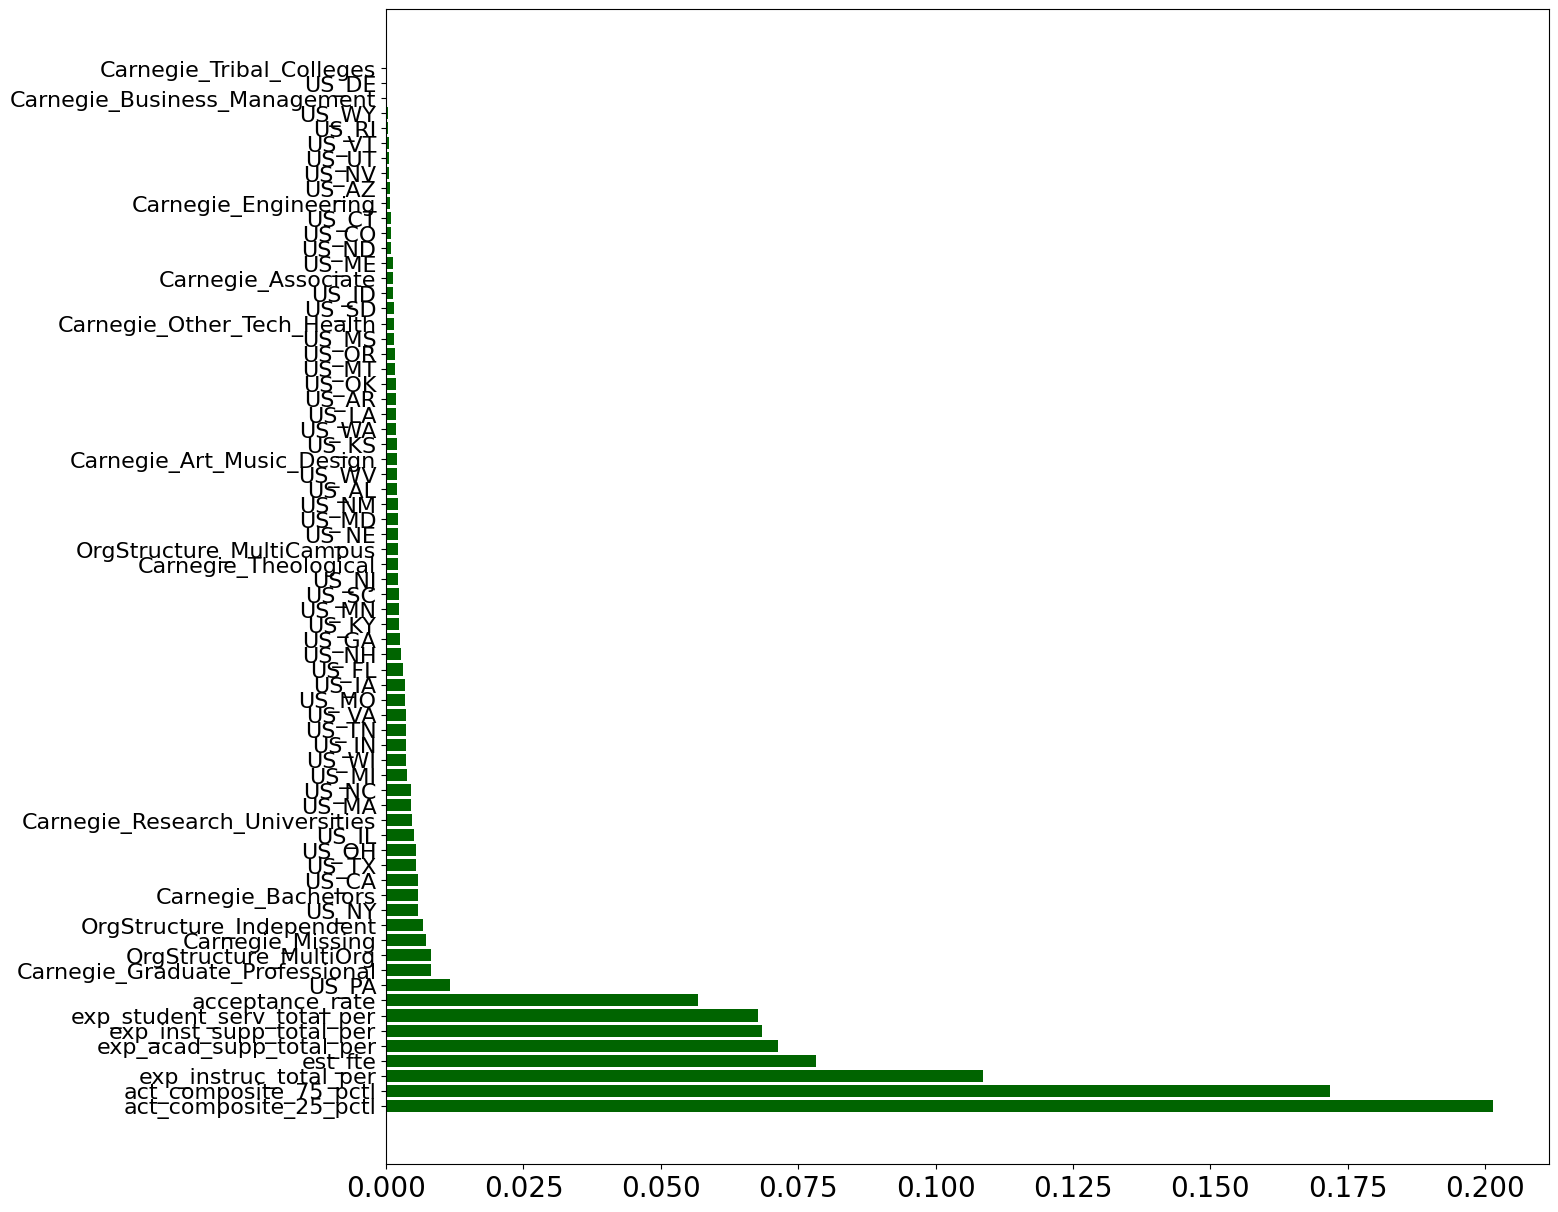

In [17]:
##plot feature importance
import matplotlib.pyplot as plt

#ax.set_title('Feature Importance All Variables')
plt.rcdefaults() 
plt.figure(figsize=(15,15))
plt.barh(range(X_train.shape[1]), importances[sorted_indices], align='center', color = "darkgreen")
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_indices], fontsize=16)
plt.xticks(fontsize=20)
plt.savefig('FeatureImportanceALLVariables.png',dpi=300)

## Trimmed Feature Importance Chart

In [18]:
##create and fit the random forest 
X_clean2  = X_clean1.iloc[: , :21]

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_clean2, y_clean1)

##grab importance values
importances = rf.feature_importances_

##sort the indices
sorted_indices = np.argsort(importances)[::-1]



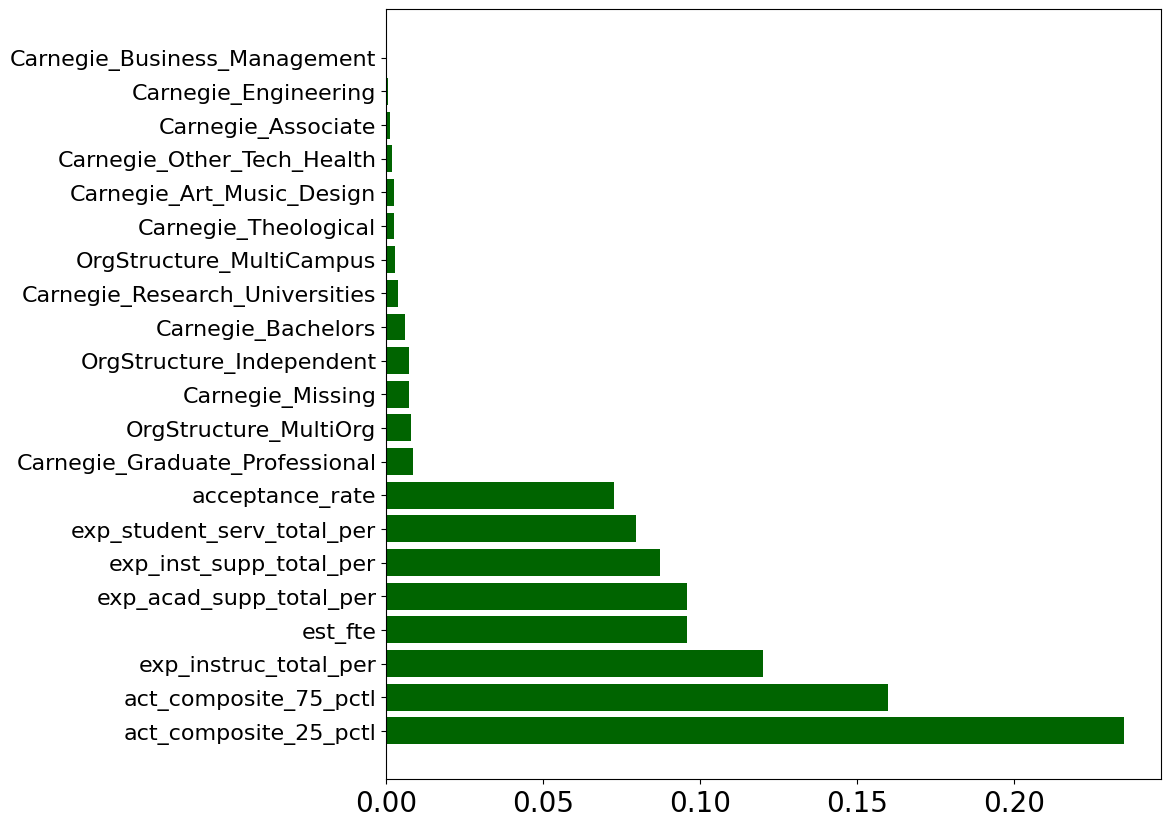

In [19]:
##plot feature importance
import matplotlib.pyplot as plt

#ax.set_title('Feature Importance All Variables')
plt.rcdefaults() 
plt.figure(figsize=(10,10))
plt.barh(range(X_clean2.shape[1]), importances[sorted_indices], align='center', color = "darkgreen")
plt.yticks(range(X_clean2.shape[1]), X_clean2.columns[sorted_indices], fontsize=16)
plt.xticks(fontsize=20)
plt.savefig('FeatureImportance21Variables.png',dpi=300)

In [20]:
## Further Trim Features to Remove those after the significant drop off after acceptance rate

In [18]:
##create subset of just desired variables from test and train
X_train = train[['est_fte', 'exp_instruc_total_per', 'exp_acad_supp_total_per', 'exp_student_serv_total_per', 'exp_inst_supp_total_per', 'act_composite_75_pctl', 'act_composite_25_pctl', 'acceptance_rate']]

X_test = test[['est_fte', 'exp_instruc_total_per', 'exp_acad_supp_total_per', 'exp_student_serv_total_per', 'exp_inst_supp_total_per',  'act_composite_75_pctl', 'act_composite_25_pctl', 'acceptance_rate']]

y_train = train.completion_rate_150pct

y_test = test.completion_rate_150pct

X_train.head(1)

est_fte  exp_instruc_total_per  exp_acad_supp_total_per  \
11618  0.804298               0.092503                 0.049112   

       exp_student_serv_total_per  exp_inst_supp_total_per  \
11618                     0.06432                 0.055147   

       act_composite_75_pctl  act_composite_25_pctl  acceptance_rate  
11618               0.236842               0.224299          0.54551

## Trimmed Correlation Matrix

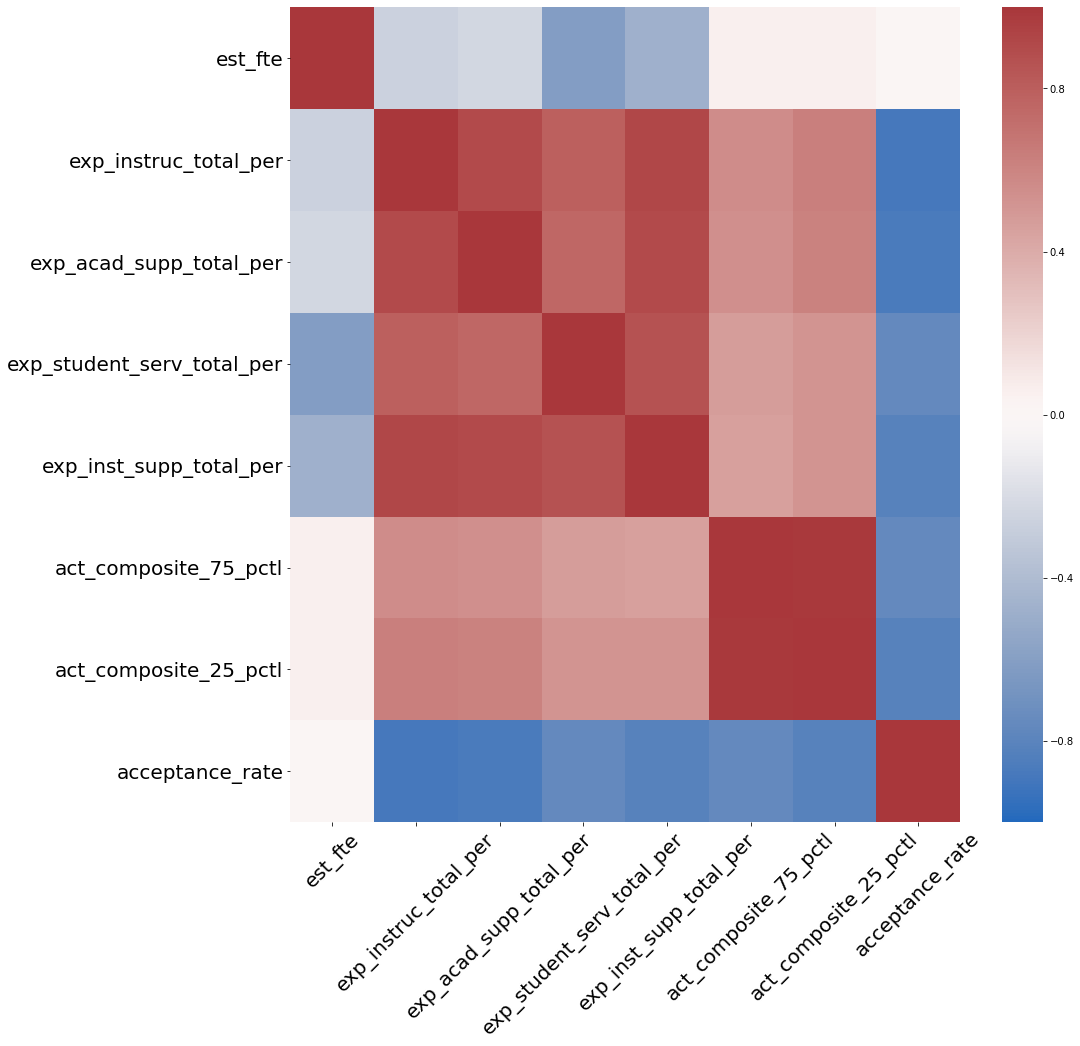

In [19]:
##View updated correlation for trimmed
##Export a matrix for presentation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
corrMatrix=X_train.corr()
plt.figure(figsize=(15,15))
plt.xticks(fontsize=20,)
plt.yticks(fontsize=20)
matrix = corrMatrix.corr().round(2)
sns.heatmap(matrix, annot=False, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.xticks(rotation = 45)
plt.savefig('CorrelationMatrixTrimmed.png',dpi=300)

## Create train and test sets for both full and trimmed datasets

In [7]:
##Create all train and test dataframes for regression and classification 
X_trainFull = train.loc[:, ~dropped.columns.isin(['unitid', 'Grad_Rates_Two_Classes', 'exp_acad_inst_student_total_per','Grad_Rates_Three_Classes', 'Grad_Rates_Quartiles', 'completion_rate_150pct', 'year', 'cc_basic_2010'])]

X_testFull = test.loc[:, ~dropped.columns.isin(['unitid', 'Grad_Rates_Two_Classes', 'exp_acad_inst_student_total_per','Grad_Rates_Three_Classes', 'Grad_Rates_Quartiles', 'completion_rate_150pct', 'year', 'cc_basic_2010'])]

X_trainTrimmed = train[['est_fte', 'exp_instruc_total_per', 'exp_acad_supp_total_per', 'exp_student_serv_total_per', 'exp_inst_supp_total_per', 'act_composite_75_pctl', 'act_composite_25_pctl', 'acceptance_rate']]

X_testTrimmed = test[['est_fte', 'exp_instruc_total_per', 'exp_acad_supp_total_per', 'exp_student_serv_total_per', 'exp_inst_supp_total_per',  'act_composite_75_pctl', 'act_composite_25_pctl', 'acceptance_rate']]

y_trainRate = train.completion_rate_150pct

y_testRate = test.completion_rate_150pct

y_train2 = train.Grad_Rates_Two_Classes

y_test2 = test.Grad_Rates_Two_Classes

y_train3 = train.Grad_Rates_Three_Classes

y_test3 = test.Grad_Rates_Three_Classes

y_train4 = train.Grad_Rates_Quartiles

y_test4 = test.Grad_Rates_Quartiles


In [8]:
##anomoly detection and outlier removal for all the sets
##regression sets
from sklearn.covariance import EllipticEnvelope
envelope1 = EllipticEnvelope(support_fraction=1, contamination=0.03).fit(X_trainFull)

outliers1 = envelope1.predict(X_trainFull)==-1  


X_cleanFullRate = X_trainFull[~outliers1]  
y_cleanFullRate = y_trainRate[~outliers1]

print(f"Num of outliers = {np.sum(outliers1)}")


from sklearn.covariance import EllipticEnvelope
envelope1b = EllipticEnvelope(support_fraction=1, contamination=0.03).fit(X_trainTrimmed)

outliers1b = envelope1b.predict(X_trainTrimmed)==-1  


X_cleanTrimmedRate = X_trainTrimmed[~outliers1b]  
y_cleanTrimmedRate = y_trainRate[~outliers1b]

print(f"Num of outliers = {np.sum(outliers1b)}")



/opt/conda/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Num of outliers = 353
Num of outliers = 353


In [9]:
##View dimensions and a window of the new dfs
print(X_cleanFullRate.shape)
print(X_cleanTrimmedRate.shape)
X_cleanTrimmedRate.head()

(11383, 70)
(11383, 8)


est_fte  exp_instruc_total_per  exp_acad_supp_total_per  \
11618  0.804298               0.092503                 0.049112   
1509   0.102860               0.021577                 0.008975   
11309  0.026311               0.030041                 0.013175   
2576   0.022347               0.021895                 0.010141   
9621   0.443424               0.049117                 0.019240   

       exp_student_serv_total_per  exp_inst_supp_total_per  \
11618                    0.064320                 0.055147   
1509                     0.016913                 0.012399   
11309                    0.075631                 0.024995   
2576                     0.072629                 0.032484   
9621                     0.015436                 0.022622   

       act_composite_75_pctl  act_composite_25_pctl  acceptance_rate  
11618               0.236842               0.224299         0.545510  
1509                0.201754               0.177570         0.607435  
11309               0.236842               0.158879         0.698295  
2576                0.219298               0.196262         0.795709  
9621                0.228070               0.205607         0.528894

In [10]:
##2 classes sets
##anomoly detection and outlier removal
from sklearn.covariance import EllipticEnvelope
envelope2 = EllipticEnvelope(support_fraction=1, contamination=0.03).fit(X_trainFull)

outliers2 = envelope2.predict(X_trainFull)==-1  


X_clean2Full = X_trainFull[~outliers2]  
y_clean2Full = y_train2[~outliers2]

print(f"Num of outliers = {np.sum(outliers2)}")


envelope2b = EllipticEnvelope(support_fraction=1, contamination=0.03).fit(X_trainTrimmed)

outliers2b = envelope2b.predict(X_trainTrimmed)==-1  


X_clean2Trimmed = X_trainTrimmed[~outliers2b]  
y_clean2Trimmed = y_train2[~outliers2b]

print(f"Num of outliers = {np.sum(outliers2b)}")


/opt/conda/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Num of outliers = 353
Num of outliers = 353


In [11]:
##3 classes
##anomoly detection and outlier removal
envelope3 = EllipticEnvelope(support_fraction=1, contamination=0.03).fit(X_trainFull)

outliers3 = envelope3.predict(X_trainFull)==-1  


X_clean3Full = X_trainFull[~outliers3]  
y_clean3Full = y_train3[~outliers3]

print(f"Num of outliers = {np.sum(outliers3)}")


envelope3b = EllipticEnvelope(support_fraction=1, contamination=0.03).fit(X_trainTrimmed)

outliers3b = envelope3b.predict(X_trainTrimmed)==-1  


X_clean3Trimmed = X_trainTrimmed[~outliers3b]  
y_clean3Trimmed = y_train3[~outliers3b]

print(f"Num of outliers = {np.sum(outliers3b)}")

/opt/conda/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Num of outliers = 353
Num of outliers = 353


In [12]:
## 4 classes
##anomoly detection and outlier removal
envelope4 = EllipticEnvelope(support_fraction=1, contamination=0.03).fit(X_trainFull)

outliers4 = envelope4.predict(X_trainFull)==-1  


X_clean4Full = X_trainFull[~outliers4]  
y_clean4Full = y_train4[~outliers4]

print(f"Num of outliers = {np.sum(outliers4)}")


envelope4b = EllipticEnvelope(support_fraction=1, contamination=0.03).fit(X_trainTrimmed)

outliers4b = envelope4b.predict(X_trainTrimmed)==-1  


X_clean4Trimmed = X_trainTrimmed[~outliers4b]  
y_clean4Trimmed = y_train4[~outliers4b]

print(f"Num of outliers = {np.sum(outliers4b)}")

/opt/conda/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Num of outliers = 353
Num of outliers = 353


# Regression

### Random Forest with Trimmed Set.  

In [21]:
##Stanard linear regression without PCA, but trimmed set. 
#set the pca_components
#pca_components = 3

pipe0 = Pipeline([
    ('LinearRegression', LinearRegression())
])

param_grid0 = {
    
    'LinearRegression__n_jobs': [1,3,5]
}



In [22]:
# Train the Pipeline with Grid Search 
model_grid0 = GridSearchCV(pipe, param_grid0, cv = 5, n_jobs = 5)
model_grid0.fit(X_cleanTrimmedRate, y_cleanTrimmedRate)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('PCA', PCA()),
                                       ('LinearRegression',
                                        LinearRegression())]),
             n_jobs=5, param_grid={'LinearRegression__n_jobs': [1, 3, 5]})

In [24]:
model_grid0.best_params_ ##Best hyperparameters

{'LinearRegression__n_jobs': 1}

In [25]:
##view results print(model_grid.best_params_)
print(model_grid0.best_score_)

0.6406247457020943


In [83]:
## get predictions
y_predicted = model_grid0.predict(X_testTrimmed)
##explained variance
explained_variance_score(y_testRate, y_predicted)

0.5612968054281691

In [29]:
##r2 score
r2_score(y_testRate, y_predicted)

0.5610813750160539

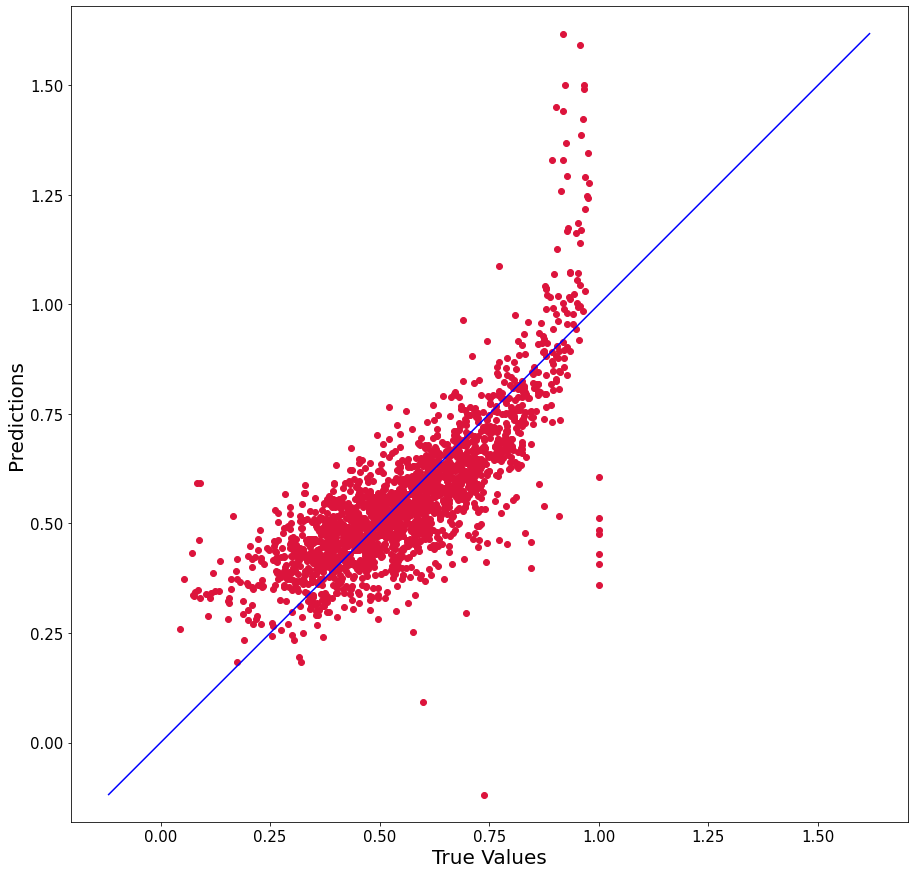

In [84]:
plt.figure(figsize=(15,15))
plt.scatter(y_testRate, y_predicted, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_predicted), max(y_testRate))
p2 = min(min(y_predicted), min(y_testRate))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=20)
plt.ylabel('Predictions', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis('equal')
plt.savefig('RegressionAcutalVsPredicted.png',dpi=300)

### Regression with PCA

In [32]:
# with all features using pca.
#pca_components = 3

pipe = Pipeline([
    ('PCA', PCA()),
    ('LinearRegression', LinearRegression())
])

In [55]:
# Configure the parameters for grid search

param_grid = {
    
    'PCA__n_components': [1, 10, 15, 20, 25, 30, 35, 40, 50, 55, 60, 65, 70],
    'LinearRegression__n_jobs': [1,3,5]
}




In [56]:
# Train the Pipeline with Grid Search 
model_grid = GridSearchCV(pipe, param_grid, cv = 5, n_jobs = 5)
model_grid.fit(X_cleanFullRate, y_cleanFullRate)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('PCA', PCA()),
                                       ('LinearRegression',
                                        LinearRegression())]),
             n_jobs=5,
             param_grid={'LinearRegression__n_jobs': [1, 3, 5],
                         'PCA__n_components': [1, 10, 15, 20, 25, 30, 35, 40,
                                               50, 55, 60, 65, 70]})

In [57]:
model_grid.best_params_ ##Best hyperparameters

{'LinearRegression__n_jobs': 1, 'PCA__n_components': 70}

In [58]:
##view results print(model_grid.best_params_)
print(model_grid.best_score_)

0.7242460606519229


In [59]:
## get predictions
y_predicted = model_grid.predict(X_testFull)
##explained variance
explained_variance_score(y_testRate, y_predicted)

0.6841386098841067

In [60]:
##r2 score
r2_score(y_testRate, y_predicted)

0.6838104860252272

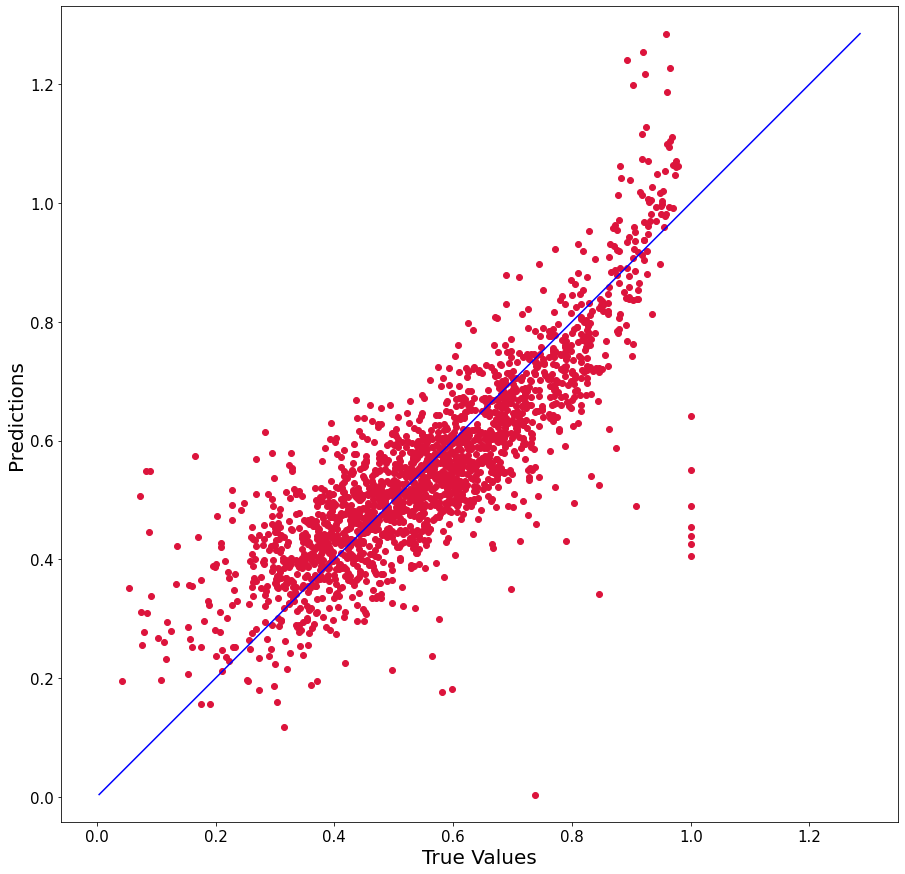

In [73]:
plt.figure(figsize=(15,15))
plt.scatter(y_testRate, y_predicted, c='crimson')
#plt.yscale('log')
#plt.xscale('log')
p1 = max(max(y_predicted), max(y_testRate))
p2 = min(min(y_predicted), min(y_testRate))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=20)
plt.ylabel('Predictions', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis('equal')
plt.savefig('RegressionAcutalVsPredictedPCA.png',dpi=300)

# Classification

### Low High

## PCA and Random Forest on all Features

In [72]:
##create second pipeline
pipe2 = Pipeline([
    ('PCA', PCA()),
    ('RandomForestClassifier', RandomForestClassifier())
])

param_grid2 = {
    'PCA__n_components': [1, 10, 30, 50, 70],
    'RandomForestClassifier__n_estimators': [50, 150],
    'RandomForestClassifier__criterion': ['gini', 'entropy'],
    'RandomForestClassifier__max_depth': [8]
}

model_grid2 = GridSearchCV(pipe2, param_grid2, cv = 5, n_jobs = 2)
model_grid2.fit(X_clean2Full, y_clean2Full)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('PCA', PCA()),
                                       ('RandomForestClassifier',
                                        RandomForestClassifier())]),
             n_jobs=2,
             param_grid={'PCA__n_components': [1, 10, 30, 50, 70],
                         'RandomForestClassifier__criterion': ['gini',
                                                               'entropy'],
                         'RandomForestClassifier__max_depth': [8],
                         'RandomForestClassifier__n_estimators': [50, 150]})

In [74]:
model_grid2.best_params_ ##Best hyperparameters

{'PCA__n_components': 70,
 'RandomForestClassifier__criterion': 'gini',
 'RandomForestClassifier__max_depth': 8,
 'RandomForestClassifier__n_estimators': 150}

In [75]:
##print model score
print(model_grid2.best_score_)

0.8418697558607393


In [76]:
##Accuracy Score
accuracy_score(y_test2, model_grid2.predict(X_testFull))

0.8404907975460123

In [77]:
##AUC
##get predictions
y_predicted = model_grid2.predict(X_testFull)

##Auc Score
fpr, tpr, thresholds = roc_curve(y_test2, y_predicted)
auc(fpr, tpr)

0.8412299446782205

In [85]:
##model evaluation 
y_predicted = model_grid2.predict(X_testFull)
y_predicted[1:20]
print(confusion_matrix(y_test2, y_predicted))
print(classification_report(y_test2, y_predicted))

[[838 119]
 [193 806]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       957
           1       0.87      0.81      0.84       999

    accuracy                           0.84      1956
   macro avg       0.84      0.84      0.84      1956
weighted avg       0.84      0.84      0.84      1956



<Figure size 1440x1440 with 0 Axes>

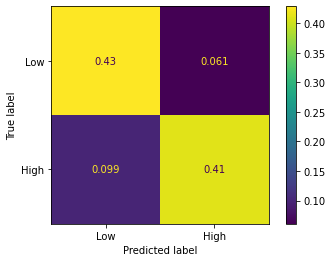

In [86]:
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(model_grid2, X_testFull, y_test2, normalize = 'all', display_labels=['Low','High'])
cmd.figure_.savefig('RandomPCA_LH_Fig1F.png',dpi=300)


## Random Forest with Trimmed Variables

In [87]:
pipe3 = Pipeline([
    ('RandomForestClassifier', RandomForestClassifier()) 
])

param_grid3 = {
    'RandomForestClassifier__n_estimators': [50, 150],
    'RandomForestClassifier__criterion': ['gini', 'entropy'],
    'RandomForestClassifier__max_depth': [8]
    
}
    
model_grid3 = GridSearchCV(pipe3, param_grid3, cv = 5, n_jobs = 5)
model_grid3.fit(X_clean2Trimmed, y_clean2Trimmed)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('RandomForestClassifier',
                                        RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'RandomForestClassifier__criterion': ['gini',
                                                               'entropy'],
                         'RandomForestClassifier__max_depth': [8],
                         'RandomForestClassifier__n_estimators': [50, 150]})

In [88]:
model_grid3.best_params_ ##Best hyperparameters

{'RandomForestClassifier__criterion': 'gini',
 'RandomForestClassifier__max_depth': 8,
 'RandomForestClassifier__n_estimators': 150}

In [89]:
##model evaluation 
y_predicted = model_grid3.predict(X_testTrimmed)
y_predicted[1:20]
print(confusion_matrix(y_test2, y_predicted))
print(classification_report(y_test2, y_predicted))

[[839 118]
 [191 808]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       957
           1       0.87      0.81      0.84       999

    accuracy                           0.84      1956
   macro avg       0.84      0.84      0.84      1956
weighted avg       0.84      0.84      0.84      1956



In [90]:
##print model score
print(model_grid3.best_score_)

0.8383546244133087


In [92]:
##Accuracy Score
accuracy_score(y_test2, model_grid3.predict(X_testTrimmed))

0.8420245398773006

In [93]:
##AUC
##get predictions
y_predicted = model_grid3.predict(X_testTrimmed)

##Auc Score
fpr, tpr, thresholds = roc_curve(y_test2, y_predicted)
auc(fpr, tpr)

0.8427534117189288

<Figure size 1440x1440 with 0 Axes>

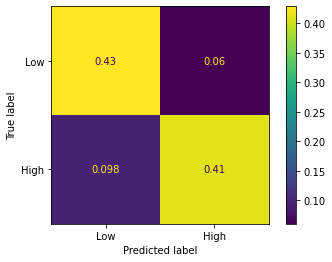

In [94]:
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(model_grid3, X_testTrimmed, y_test2, normalize = 'all', display_labels=['Low','High'])
cmd.figure_.savefig('Random_LH_Fig2F.png',dpi=300)



### Decision tree

In [95]:
pipeDT2 = Pipeline([
    ('DecisionTreeClassifier', DecisionTreeClassifier()) 
])

param_gridDT2 = {
    'DecisionTreeClassifier__min_samples_leaf': [10, 50, 150, 300],
    'DecisionTreeClassifier__criterion': ['gini', 'entropy'],
    'DecisionTreeClassifier__max_depth': [5, 10, 15, 20]
    
}
    
model_gridDT2 = GridSearchCV(pipeDT2, param_gridDT2, cv = 5, n_jobs = 5)
model_gridDT2.fit(X_clean2Trimmed, y_clean2Trimmed)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('DecisionTreeClassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=5,
             param_grid={'DecisionTreeClassifier__criterion': ['gini',
                                                               'entropy'],
                         'DecisionTreeClassifier__max_depth': [5, 10, 15, 20],
                         'DecisionTreeClassifier__min_samples_leaf': [10, 50,
                                                                      150,
                                                                      300]})

In [96]:
model_gridDT2.best_params_ ##Best hyperparameters

{'DecisionTreeClassifier__criterion': 'gini',
 'DecisionTreeClassifier__max_depth': 5,
 'DecisionTreeClassifier__min_samples_leaf': 150}

In [98]:
##model evaluation 
y_predicted = model_gridDT2.predict(X_testTrimmed)
y_predicted[1:20]
print(confusion_matrix(y_test2, y_predicted))
print(classification_report(y_test2, y_predicted))

[[822 135]
 [219 780]]
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       957
           1       0.85      0.78      0.82       999

    accuracy                           0.82      1956
   macro avg       0.82      0.82      0.82      1956
weighted avg       0.82      0.82      0.82      1956



In [99]:
##print model score
print(model_gridDT2.best_score_)

0.8174472238237808


In [100]:
##Accuracy Score
accuracy_score(y_test2, model_gridDT2.predict(X_testTrimmed))

0.8190184049079755

In [101]:
##AUC
##get predictions
y_predicted = model_gridDT2.predict(X_testTrimmed)

##Auc Score
fpr, tpr, thresholds = roc_curve(y_test2, y_predicted)
auc(fpr, tpr)

0.8198574750298888

<Figure size 1440x1440 with 0 Axes>

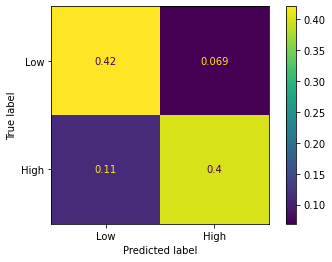

In [102]:
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(model_gridDT2, X_testTrimmed, y_test2, normalize = 'all', display_labels=['Low','High'])
cmd.figure_.savefig('DecisionTree_LH_Fig2F.png',dpi=300)


## Decision Tree without gridsearchcv

In [103]:
##create decision tree.
clf = DecisionTreeClassifier(max_depth = 5, criterion = 'gini', min_samples_leaf = 150, random_state=21)
model = clf.fit(X_clean2Trimmed, y_clean2Trimmed)

In [104]:
#create feature col
feature_cols = []
for i in X_clean2Trimmed.columns.values:
    feature_cols.append(i)
type(feature_cols)
target_names=['Low','High']
feature_cols
X = X_clean2Trimmed
y = y_clean2Trimmed

In [105]:
## Accuracy
pred = clf.predict(X_testTrimmed)
acc = accuracy_score(pred, y_test2)
acc

0.8190184049079755

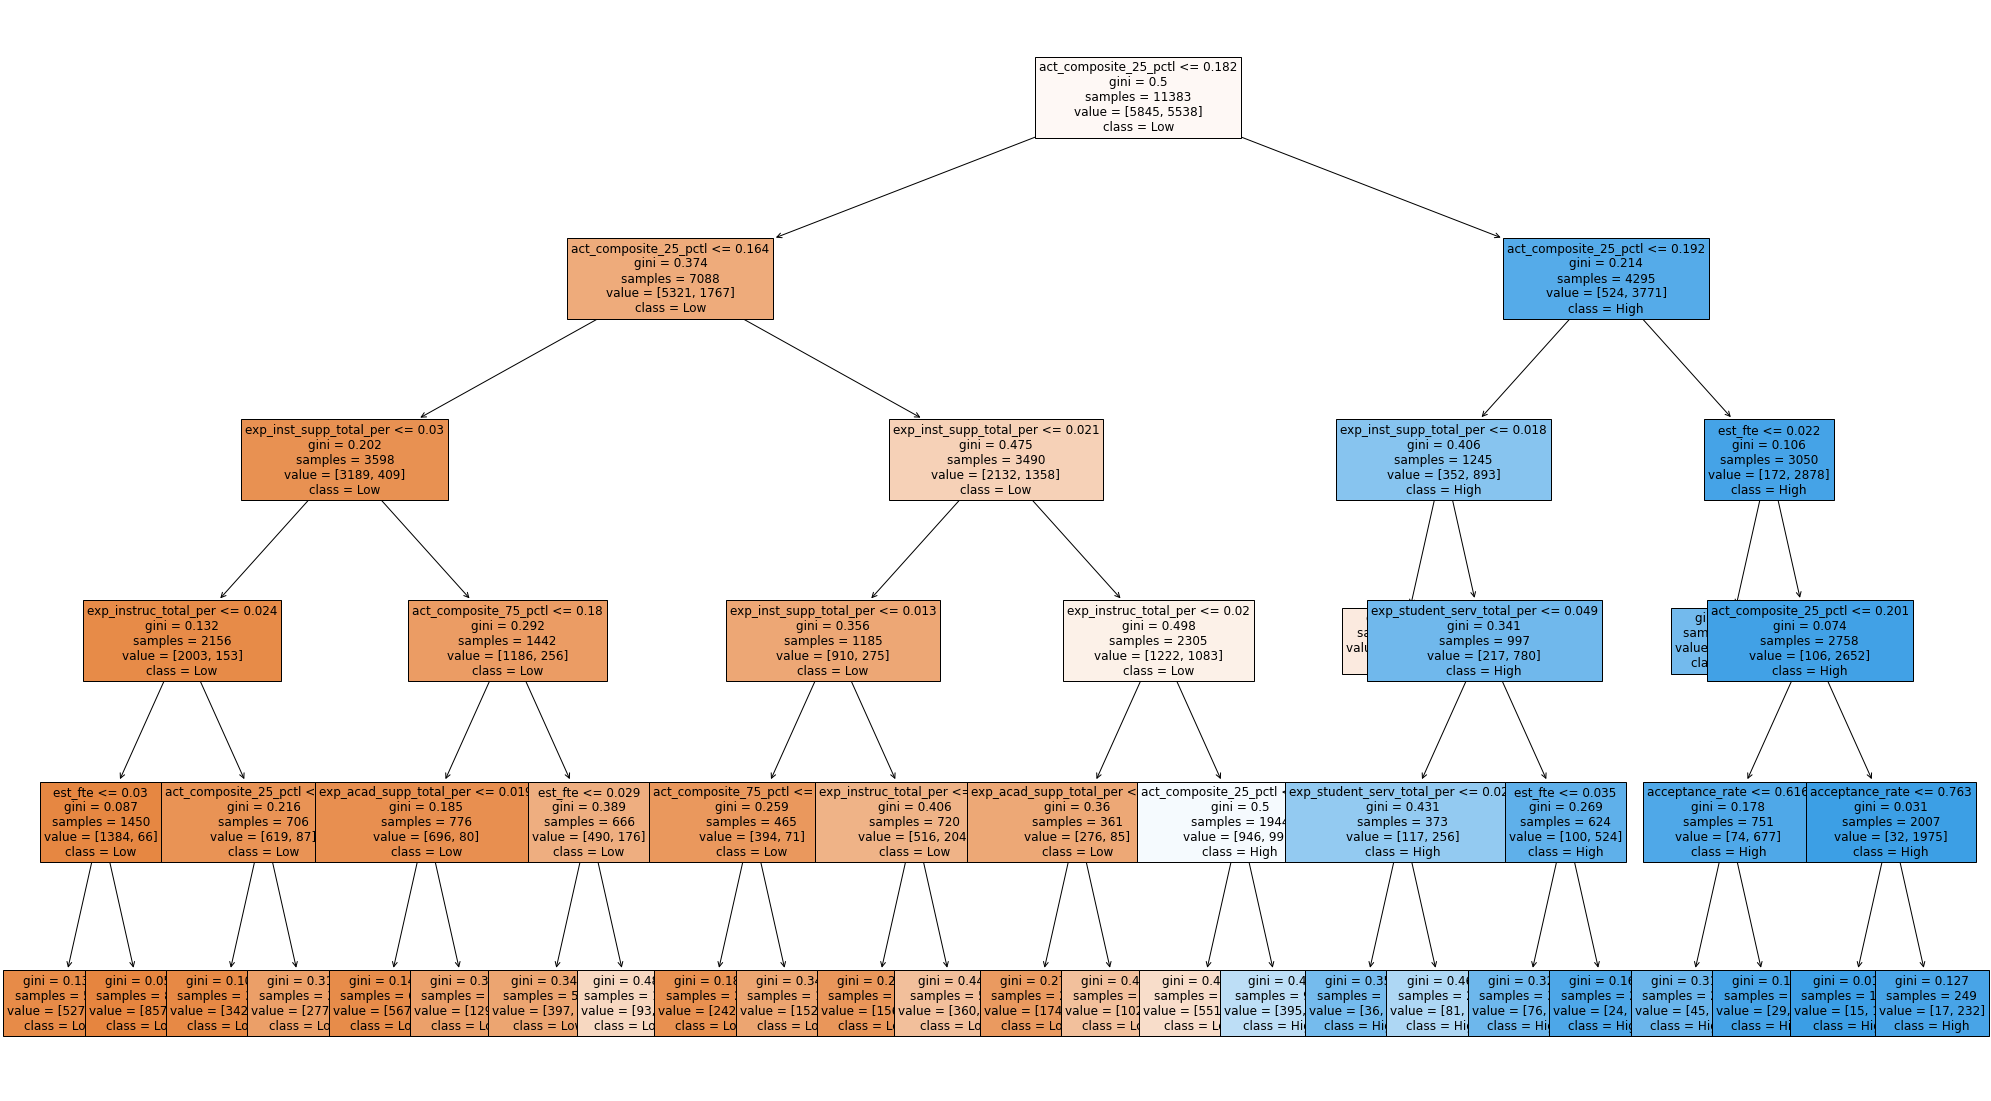

In [106]:
##Plot decision tree
fig = plt.figure(figsize=(35,20))
_ = tree.plot_tree(clf, fontsize=12,
                   feature_names=feature_cols,  
                   class_names=target_names,
                   filled=True)
fig.savefig('Tree2ClassF.png',dpi=300)



## Dummy Classifier

In [110]:
pipeDum2 = Pipeline([
    ('DummyClassifier', DummyClassifier()) 
])

param_gridDum2 = {
    'DummyClassifier__strategy': ['most_frequent', 'prior', 'stratified', 'uniform'],
}
    
model_gridDum2 = GridSearchCV(pipeDum2, param_gridDum2, cv = 5, n_jobs = 5)
model_gridDum2.fit(X_clean2Trimmed, y_clean2Trimmed)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('DummyClassifier', DummyClassifier())]),
             n_jobs=5,
             param_grid={'DummyClassifier__strategy': ['most_frequent', 'prior',
                                                       'stratified',
                                                       'uniform']})

In [112]:
model_gridDum2.best_params_ ##Best hyperparameters

{'DummyClassifier__strategy': 'most_frequent'}

In [115]:
##model evaluation 
y_predicted = model_gridDum2.predict(X_testTrimmed)
y_predicted[1:20]
print(confusion_matrix(y_test2, y_predicted))
print(classification_report(y_test2, y_predicted))

[[957   0]
 [999   0]]
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       957
           1       0.00      0.00      0.00       999

    accuracy                           0.49      1956
   macro avg       0.24      0.50      0.33      1956
weighted avg       0.24      0.49      0.32      1956



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [117]:
##print model score
print(model_gridDum2.best_score_)

0.5134850453028799


In [116]:
##Accuracy Score
accuracy_score(y_test2, model_gridDum2.predict(X_testTrimmed))

0.4892638036809816

In [118]:
##AUC
##get predictions
y_predicted = model_gridDum2.predict(X_testTrimmed)

##Auc Score
fpr, tpr, thresholds = roc_curve(y_test2, y_predicted)
auc(fpr, tpr)

0.5

<Figure size 1440x1440 with 0 Axes>

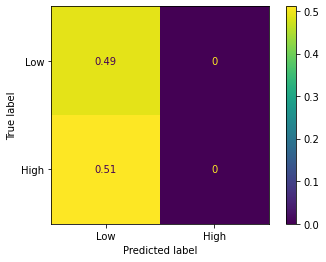

In [119]:
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(model_gridDum2, X_testTrimmed, y_test2, normalize = 'all', display_labels=['Low','High'])
cmd.figure_.savefig('Dummy_LH_Fig2F.png',dpi=300)


## Low Medium High

## PCA and Random Forest on all Features

In [126]:
pipe4 = Pipeline([
    ('PCA', PCA()),
    ('RandomForestClassifier', RandomForestClassifier())
])

param_grid4 = {
    'PCA__n_components': [1, 10, 30, 50, 70],
    'RandomForestClassifier__n_estimators': [50, 150],
    'RandomForestClassifier__criterion': ['gini', 'entropy'],
    'RandomForestClassifier__max_depth': [8]
}

model_grid4 = GridSearchCV(pipe4, param_grid4, cv = 5, n_jobs = 2)
model_grid4.fit(X_clean3Full, y_clean3Full)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('PCA', PCA()),
                                       ('RandomForestClassifier',
                                        RandomForestClassifier())]),
             n_jobs=2,
             param_grid={'PCA__n_components': [1, 10, 30, 50, 70],
                         'RandomForestClassifier__criterion': ['gini',
                                                               'entropy'],
                         'RandomForestClassifier__max_depth': [8],
                         'RandomForestClassifier__n_estimators': [50, 150]})

In [127]:
model_grid4.best_params_ ##Best hyperparameters

{'PCA__n_components': 70,
 'RandomForestClassifier__criterion': 'entropy',
 'RandomForestClassifier__max_depth': 8,
 'RandomForestClassifier__n_estimators': 150}

In [128]:
##print model score
print(model_grid4.best_score_)

0.7322306120732038


In [129]:
##Accuracy Score
accuracy_score(y_test3, model_grid4.predict(X_testFull))

0.7361963190184049

In [130]:
#roc_auc_score(y_test, model_grid3.predict_proba(X_test)[:,1])
#Calculate the y_score
y_score = model_grid4.predict_proba(X_testFull)

##get auc score
roc_auc_score(y_test3, y_score, multi_class='ovr')

0.8893431742071044

<Figure size 1440x1440 with 0 Axes>

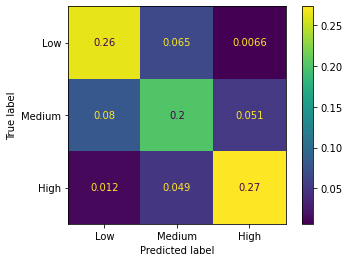

In [131]:
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(model_grid4, X_testFull, y_test3, normalize = 'all', display_labels=['Low','Medium', 'High'])
cmd.figure_.savefig('PCARandom_LMH_Fig3F.png',dpi=300)

## Random Forest

In [132]:
pipe5 = Pipeline([
    ('RandomForestClassifier', RandomForestClassifier()) 
])

param_grid5 = {
    'RandomForestClassifier__n_estimators': [50, 150],
    'RandomForestClassifier__criterion': ['gini', 'entropy'],
    'RandomForestClassifier__max_depth': [8]
    
}
    
model_grid5 = GridSearchCV(pipe5, param_grid5, cv = 5, n_jobs = 5)
model_grid5.fit(X_clean3Trimmed, y_clean3Trimmed)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('RandomForestClassifier',
                                        RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'RandomForestClassifier__criterion': ['gini',
                                                               'entropy'],
                         'RandomForestClassifier__max_depth': [8],
                         'RandomForestClassifier__n_estimators': [50, 150]})

In [133]:
model_grid5.best_params_ ##Best hyperparameters

{'RandomForestClassifier__criterion': 'gini',
 'RandomForestClassifier__max_depth': 8,
 'RandomForestClassifier__n_estimators': 150}

In [134]:
##model evaluation 
y_predicted = model_grid5.predict(X_testTrimmed)
y_predicted[1:20]
print(confusion_matrix(y_test3, y_predicted))
print(classification_report(y_test3, y_predicted))

[[503 143   9]
 [170 386  92]
 [ 28 109 516]]
              precision    recall  f1-score   support

           0       0.72      0.77      0.74       655
           1       0.61      0.60      0.60       648
           2       0.84      0.79      0.81       653

    accuracy                           0.72      1956
   macro avg       0.72      0.72      0.72      1956
weighted avg       0.72      0.72      0.72      1956



In [135]:
##print model score
print(model_grid5.best_score_)

0.7190543395288562


In [136]:
##Accuracy Score
accuracy_score(y_test3, model_grid5.predict(X_testTrimmed))

0.7183026584867076

In [137]:
#roc_auc_score(y_test, model_grid3.predict_proba(X_test)[:,1])
#Calculate the y_score
y_score = model_grid5.predict_proba(X_testTrimmed)

##get auc score
roc_auc_score(y_test3, y_score, multi_class='ovr')

0.8842140672359636

<Figure size 1440x1440 with 0 Axes>

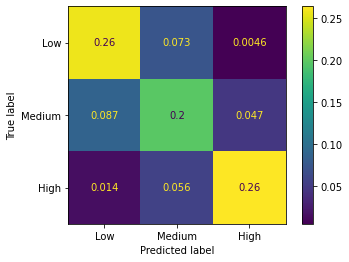

In [138]:
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(model_grid5, X_testTrimmed, y_test3, normalize = 'all', display_labels=['Low', 'Medium','High'])
cmd.figure_.savefig('Random_LMH_Fig4F.png',dpi=300)



## Decision Tree

In [139]:
pipeDT3 = Pipeline([
    ('DecisionTreeClassifier', DecisionTreeClassifier()) 
])

param_gridDT3 = {
    'DecisionTreeClassifier__min_samples_leaf': [10, 50, 150, 300],
    'DecisionTreeClassifier__criterion': ['gini', 'entropy'],
    'DecisionTreeClassifier__max_depth': [5, 10, 15, 20]
    
}
    
model_gridDT3 = GridSearchCV(pipeDT3, param_gridDT3, cv = 5, n_jobs = 5)
model_gridDT3.fit(X_clean3Trimmed, y_clean3Trimmed)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('DecisionTreeClassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=5,
             param_grid={'DecisionTreeClassifier__criterion': ['gini',
                                                               'entropy'],
                         'DecisionTreeClassifier__max_depth': [5, 10, 15, 20],
                         'DecisionTreeClassifier__min_samples_leaf': [10, 50,
                                                                      150,
                                                                      300]})

In [145]:
print(model_gridDT3.best_params_) ##Best hyperparameters
##model evaluation 
##get predictions
y_predicted = model_gridDT3.predict(X_testTrimmed)
print(confusion_matrix(y_test3, y_predicted))
print(classification_report(y_test3, y_predicted))
##print model score
print("Model Score", model_gridDT3.best_score_)
##Accuracy Score
print("Accuracy Score",accuracy_score(y_test3, model_gridDT3.predict(X_testTrimmed)))

##get auc score
#Calculate the y_score
y_score = model_gridDT3.predict_proba(X_testTrimmed)

print("AUC Score", roc_auc_score(y_test3, y_score, multi_class='ovr'))

{'DecisionTreeClassifier__criterion': 'gini', 'DecisionTreeClassifier__max_depth': 10, 'DecisionTreeClassifier__min_samples_leaf': 50}
[[468 172  15]
 [164 375 109]
 [ 27 125 501]]
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       655
           1       0.56      0.58      0.57       648
           2       0.80      0.77      0.78       653

    accuracy                           0.69      1956
   macro avg       0.69      0.69      0.69      1956
weighted avg       0.69      0.69      0.69      1956

Model Score 0.6807513509049385
Accuracy Score 0.6871165644171779
AUC Score 0.8531655331494479


<Figure size 1440x1440 with 0 Axes>

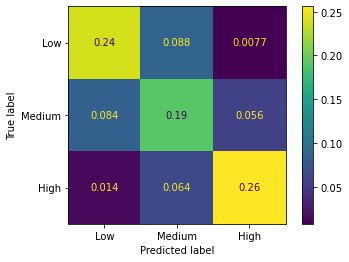

In [146]:
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(model_gridDT3, X_testTrimmed, y_test3, normalize = 'all', display_labels=['Low','Medium','High'])
cmd.figure_.savefig('DecisionTree_LMH_Fig4F.png',dpi=300)


## Decision Tree without gridsearchcv

In [149]:
##create decision tree.
clf = DecisionTreeClassifier(max_depth = 10, criterion = 'gini', min_samples_leaf = 50, random_state=21)
model = clf.fit(X_clean3Trimmed, y_clean3Trimmed)

In [150]:
#create feature col
feature_cols = []
for i in X_clean3Trimmed.columns.values:
    feature_cols.append(i)
type(feature_cols)
target_names=['Low', 'Medium', 'High']
feature_cols
X = X_clean3Trimmed
y = y_clean3Trimmed

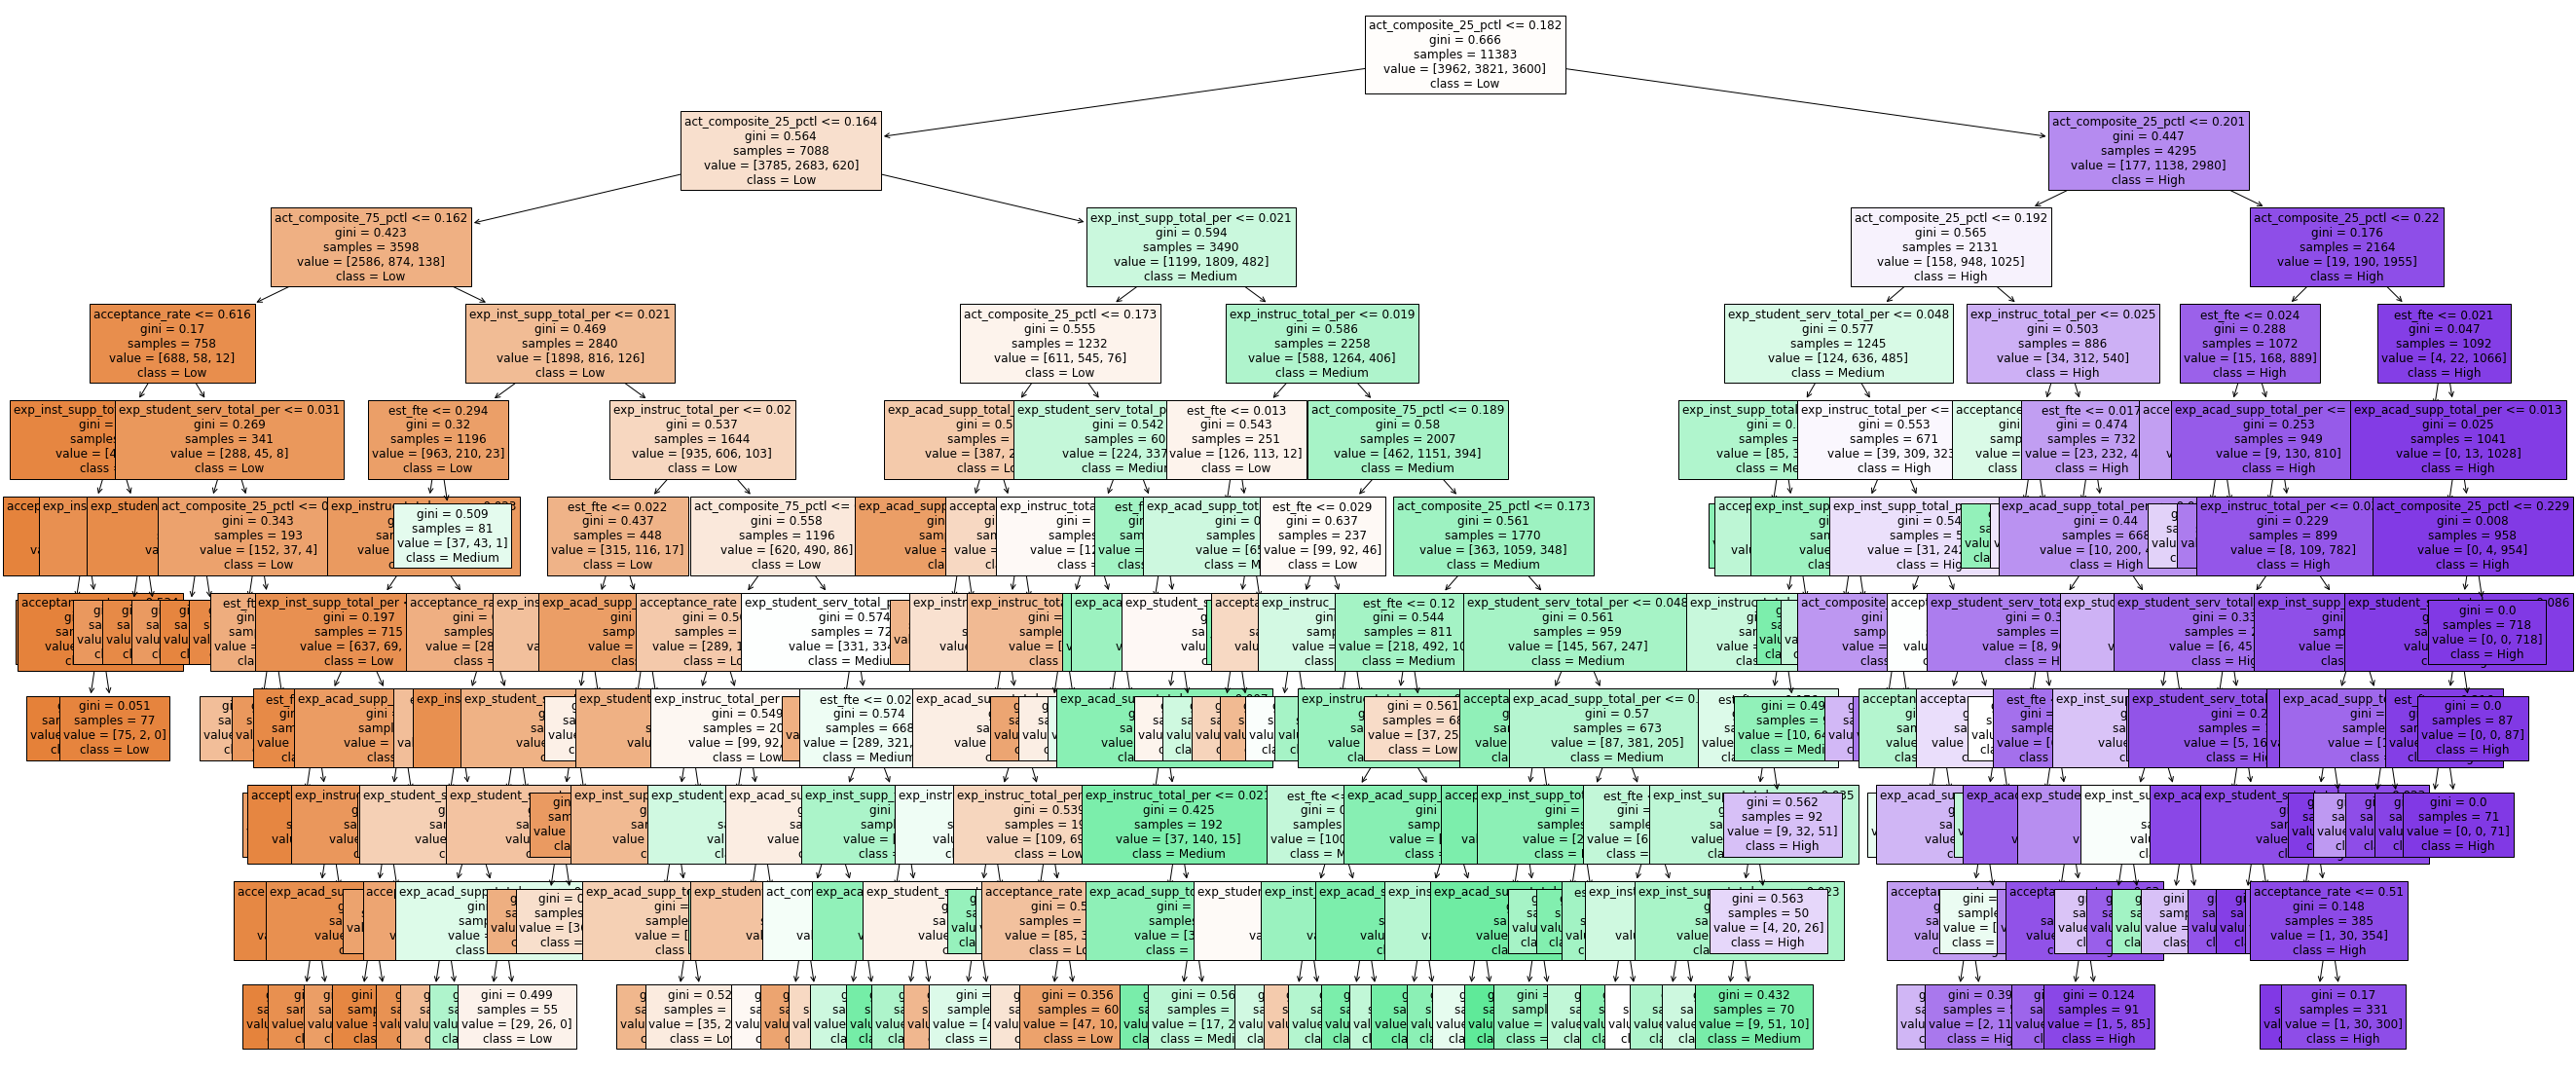

In [151]:
##Plot decision tree
fig = plt.figure(figsize=(45,20))
_ = tree.plot_tree(clf, fontsize=12,
                   feature_names=feature_cols,  
                   class_names=target_names,
                   filled=True)
fig.savefig('Tree3ClassF.png',dpi=300)




In [152]:
## Accuracy
pred = clf.predict(X_testTrimmed)
acc = accuracy_score(pred, y_test3)
acc

0.6886503067484663

## Dummy Classifier

In [13]:
pipeDum3 = Pipeline([
    ('DummyClassifier', DummyClassifier()) 
])

param_gridDum3 = {
    'DummyClassifier__strategy': ['most_frequent', 'prior', 'stratified', 'uniform'],
}
    
model_gridDum3 = GridSearchCV(pipeDum3, param_gridDum3, cv = 5, n_jobs = 5)
model_gridDum3.fit(X_clean3Trimmed, y_clean3Trimmed)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('DummyClassifier', DummyClassifier())]),
             n_jobs=5,
             param_grid={'DummyClassifier__strategy': ['most_frequent', 'prior',
                                                       'stratified',
                                                       'uniform']})

In [15]:
model_gridDum3.best_params_ ##Best hyperparameters

{'DummyClassifier__strategy': 'most_frequent'}

In [17]:
##model evaluation 
y_predicted = model_gridDum3.predict(X_testTrimmed)
y_predicted[1:20]
print(confusion_matrix(y_test3, y_predicted))
print(classification_report(y_test3, y_predicted))


##print model score
print("Model Score:", model_gridDum3.best_score_)

##Accuracy Score
print("Accuracy Score:",accuracy_score(y_test3, model_gridDum3.predict(X_testTrimmed)))

#Calculate the y_score
y_score = model_gridDum3.predict_proba(X_testTrimmed)

print("AUC Score", roc_auc_score(y_test3, y_score, multi_class='ovr'))

[[655   0   0]
 [648   0   0]
 [653   0   0]]
              precision    recall  f1-score   support

           0       0.33      1.00      0.50       655
           1       0.00      0.00      0.00       648
           2       0.00      0.00      0.00       653

    accuracy                           0.33      1956
   macro avg       0.11      0.33      0.17      1956
weighted avg       0.11      0.33      0.17      1956

Model Score: 0.3480628860624276
Accuracy Score: 0.33486707566462165
AUC Score 0.5


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1440x1440 with 0 Axes>

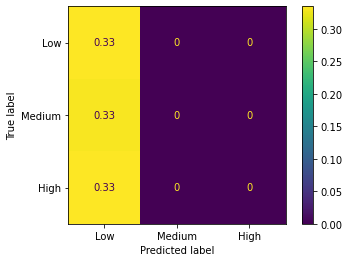

In [24]:
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(model_gridDum3, X_testTrimmed, y_test3, normalize = 'all', display_labels=['Low','Medium','High'])
cmd.figure_.savefig('Dummy_LMH_Fig4F.png',dpi=300)

## Quartiles

## PCA and Random Forest on all Features


In [18]:
pipe6 = Pipeline([
    ('PCA', PCA()),
    ('RandomForestClassifier', RandomForestClassifier())
])

param_grid6 = {
    'PCA__n_components': [1, 10, 30, 50, 70],
    'RandomForestClassifier__n_estimators': [50, 150],
    'RandomForestClassifier__criterion': ['gini', 'entropy'],
    'RandomForestClassifier__max_depth': [8]
}

model_grid6 = GridSearchCV(pipe6, param_grid6, cv = 5, n_jobs = 2)
model_grid6.fit(X_clean4Full, y_clean4Full)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('PCA', PCA()),
                                       ('RandomForestClassifier',
                                        RandomForestClassifier())]),
             n_jobs=2,
             param_grid={'PCA__n_components': [1, 10, 30, 50, 70],
                         'RandomForestClassifier__criterion': ['gini',
                                                               'entropy'],
                         'RandomForestClassifier__max_depth': [8],
                         'RandomForestClassifier__n_estimators': [50, 150]})

In [19]:
model_grid6.best_params_ ##Best hyperparameters

{'PCA__n_components': 70,
 'RandomForestClassifier__criterion': 'entropy',
 'RandomForestClassifier__max_depth': 8,
 'RandomForestClassifier__n_estimators': 150}

In [20]:
##print model score
print(model_grid6.best_score_)

0.6550116817290348


In [21]:
##Accuracy Score
accuracy_score(y_test4, model_grid6.predict(X_testFull))

0.6451942740286298

In [22]:
#roc_auc_score(y_test, model_grid3.predict_proba(X_test)[:,1])
#Calculate the y_score
y_score = model_grid6.predict_proba(X_testFull)

##get auc score
roc_auc_score(y_test4, y_score, multi_class='ovr')

0.8741130496755417

<Figure size 1440x1440 with 0 Axes>

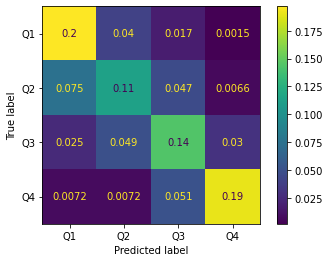

In [25]:
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(model_grid6, X_testFull, y_test4, normalize = 'all', display_labels=['Q1','Q2', 'Q3','Q4'])
cmd.figure_.savefig('PCARandom_Quart_Fig5F.png',dpi=300)

## Random Forest with Trimmed Set

In [26]:
pipe7 = Pipeline([
    ('RandomForestClassifier', RandomForestClassifier()) 
])

param_grid7 = {
    'RandomForestClassifier__n_estimators': [50, 150],
    'RandomForestClassifier__criterion': ['gini', 'entropy'],
    'RandomForestClassifier__max_depth': [8]
    
}
    
model_grid7 = GridSearchCV(pipe7, param_grid7, cv = 5, n_jobs = 5)
model_grid7.fit(X_clean4Trimmed, y_clean4Trimmed)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('RandomForestClassifier',
                                        RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'RandomForestClassifier__criterion': ['gini',
                                                               'entropy'],
                         'RandomForestClassifier__max_depth': [8],
                         'RandomForestClassifier__n_estimators': [50, 150]})

In [27]:
model_grid7.best_params_ ##Best hyperparameters

{'RandomForestClassifier__criterion': 'entropy',
 'RandomForestClassifier__max_depth': 8,
 'RandomForestClassifier__n_estimators': 50}

In [28]:
##model evaluation 
y_predicted = model_grid7.predict(X_testTrimmed)
y_predicted[1:20]
print(confusion_matrix(y_test4, y_predicted))
print(classification_report(y_test4, y_predicted))

[[370 111  17   1]
 [131 226 107   8]
 [ 36 114 272  63]
 [ 10  14 108 368]]
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       499
           1       0.49      0.48      0.48       472
           2       0.54      0.56      0.55       485
           3       0.84      0.74      0.78       500

    accuracy                           0.63      1956
   macro avg       0.63      0.63      0.63      1956
weighted avg       0.64      0.63      0.63      1956



In [29]:
##print model score
print(model_grid7.best_score_)

0.6278644934868669


In [30]:
##Accuracy Score
accuracy_score(y_test4, model_grid7.predict(X_testTrimmed))

0.6319018404907976

In [31]:
#roc_auc_score(y_test, model_grid3.predict_proba(X_test)[:,1])
#Calculate the y_score
y_score = model_grid7.predict_proba(X_testTrimmed)

##get auc score
roc_auc_score(y_test4, y_score, multi_class='ovr')

0.8677186285233699

<Figure size 1440x1440 with 0 Axes>

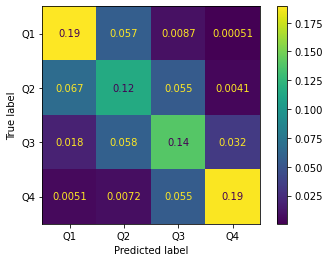

In [32]:
##Plot pretty confusion matrix
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(model_grid7, X_testTrimmed, y_test4, normalize = 'all', display_labels=['Q1', 'Q2','Q3', 'Q4'])
cmd.figure_.savefig('Random_Quart_Fig6F.png',dpi=300)


## Decision Tree on Trimmed Set

In [33]:
pipeDT4 = Pipeline([
    ('DecisionTreeClassifier', DecisionTreeClassifier()) 
])

param_gridDT4 = {
    'DecisionTreeClassifier__min_samples_leaf': [10, 50, 150, 300],
    'DecisionTreeClassifier__criterion': ['gini', 'entropy'],
    'DecisionTreeClassifier__max_depth': [5, 10, 15, 20]
    
}
    
model_gridDT4 = GridSearchCV(pipeDT4, param_gridDT4, cv = 5, n_jobs = 5)
model_gridDT4.fit(X_clean4Trimmed, y_clean4Trimmed)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('DecisionTreeClassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=5,
             param_grid={'DecisionTreeClassifier__criterion': ['gini',
                                                               'entropy'],
                         'DecisionTreeClassifier__max_depth': [5, 10, 15, 20],
                         'DecisionTreeClassifier__min_samples_leaf': [10, 50,
                                                                      150,
                                                                      300]})

In [34]:
print(model_gridDT4.best_params_) ##Best hyperparameters
##model evaluation 
##get predictions
y_predicted = model_gridDT4.predict(X_testTrimmed)
print(confusion_matrix(y_test4, y_predicted))
print(classification_report(y_test4, y_predicted))
##print model score
print("Model Score", model_gridDT4.best_score_)
##Accuracy Score
print("Accuracy Score",accuracy_score(y_test4, model_gridDT4.predict(X_testTrimmed)))

##get auc score
#Calculate the y_score
y_score = model_gridDT4.predict_proba(X_testTrimmed)

print("AUC Score", roc_auc_score(y_test4, y_score, multi_class='ovr'))

{'DecisionTreeClassifier__criterion': 'gini', 'DecisionTreeClassifier__max_depth': 10, 'DecisionTreeClassifier__min_samples_leaf': 50}
[[351 113  34   1]
 [129 219 118   6]
 [ 44 125 250  66]
 [ 11  25 123 341]]
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       499
           1       0.45      0.46      0.46       472
           2       0.48      0.52      0.50       485
           3       0.82      0.68      0.75       500

    accuracy                           0.59      1956
   macro avg       0.60      0.59      0.59      1956
weighted avg       0.61      0.59      0.60      1956

Model Score 0.5870157986991487
Accuracy Score 0.593558282208589
AUC Score 0.8390671278900932


<Figure size 1440x1440 with 0 Axes>

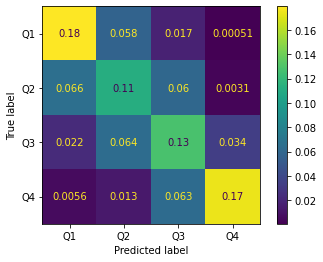

In [35]:
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(model_gridDT4, X_testTrimmed, y_test4, normalize = 'all', display_labels=['Q1','Q2','Q3', 'Q4'])
cmd.figure_.savefig('DecisionTree_Quart_Fig5F.png',dpi=300)


## Decision Tree without gridsearchcv

In [42]:
clf = DecisionTreeClassifier(max_depth = 10, criterion = 'gini', min_samples_leaf = 50, random_state=21)
model = clf.fit(X_clean4Trimmed, y_clean4Trimmed)

In [43]:
## Accuracy
pred = clf.predict(X_testTrimmed)
acc = accuracy_score(pred, y_test4)
acc

0.593558282208589

In [44]:
#create feature col
feature_cols = []
for i in X_clean4Trimmed.columns.values:
    feature_cols.append(i)
type(feature_cols)
target_names=['Q1', 'Q2', 'Q3', 'Q4']
feature_cols
X = X_clean4Trimmed
y = y_clean4Trimmed

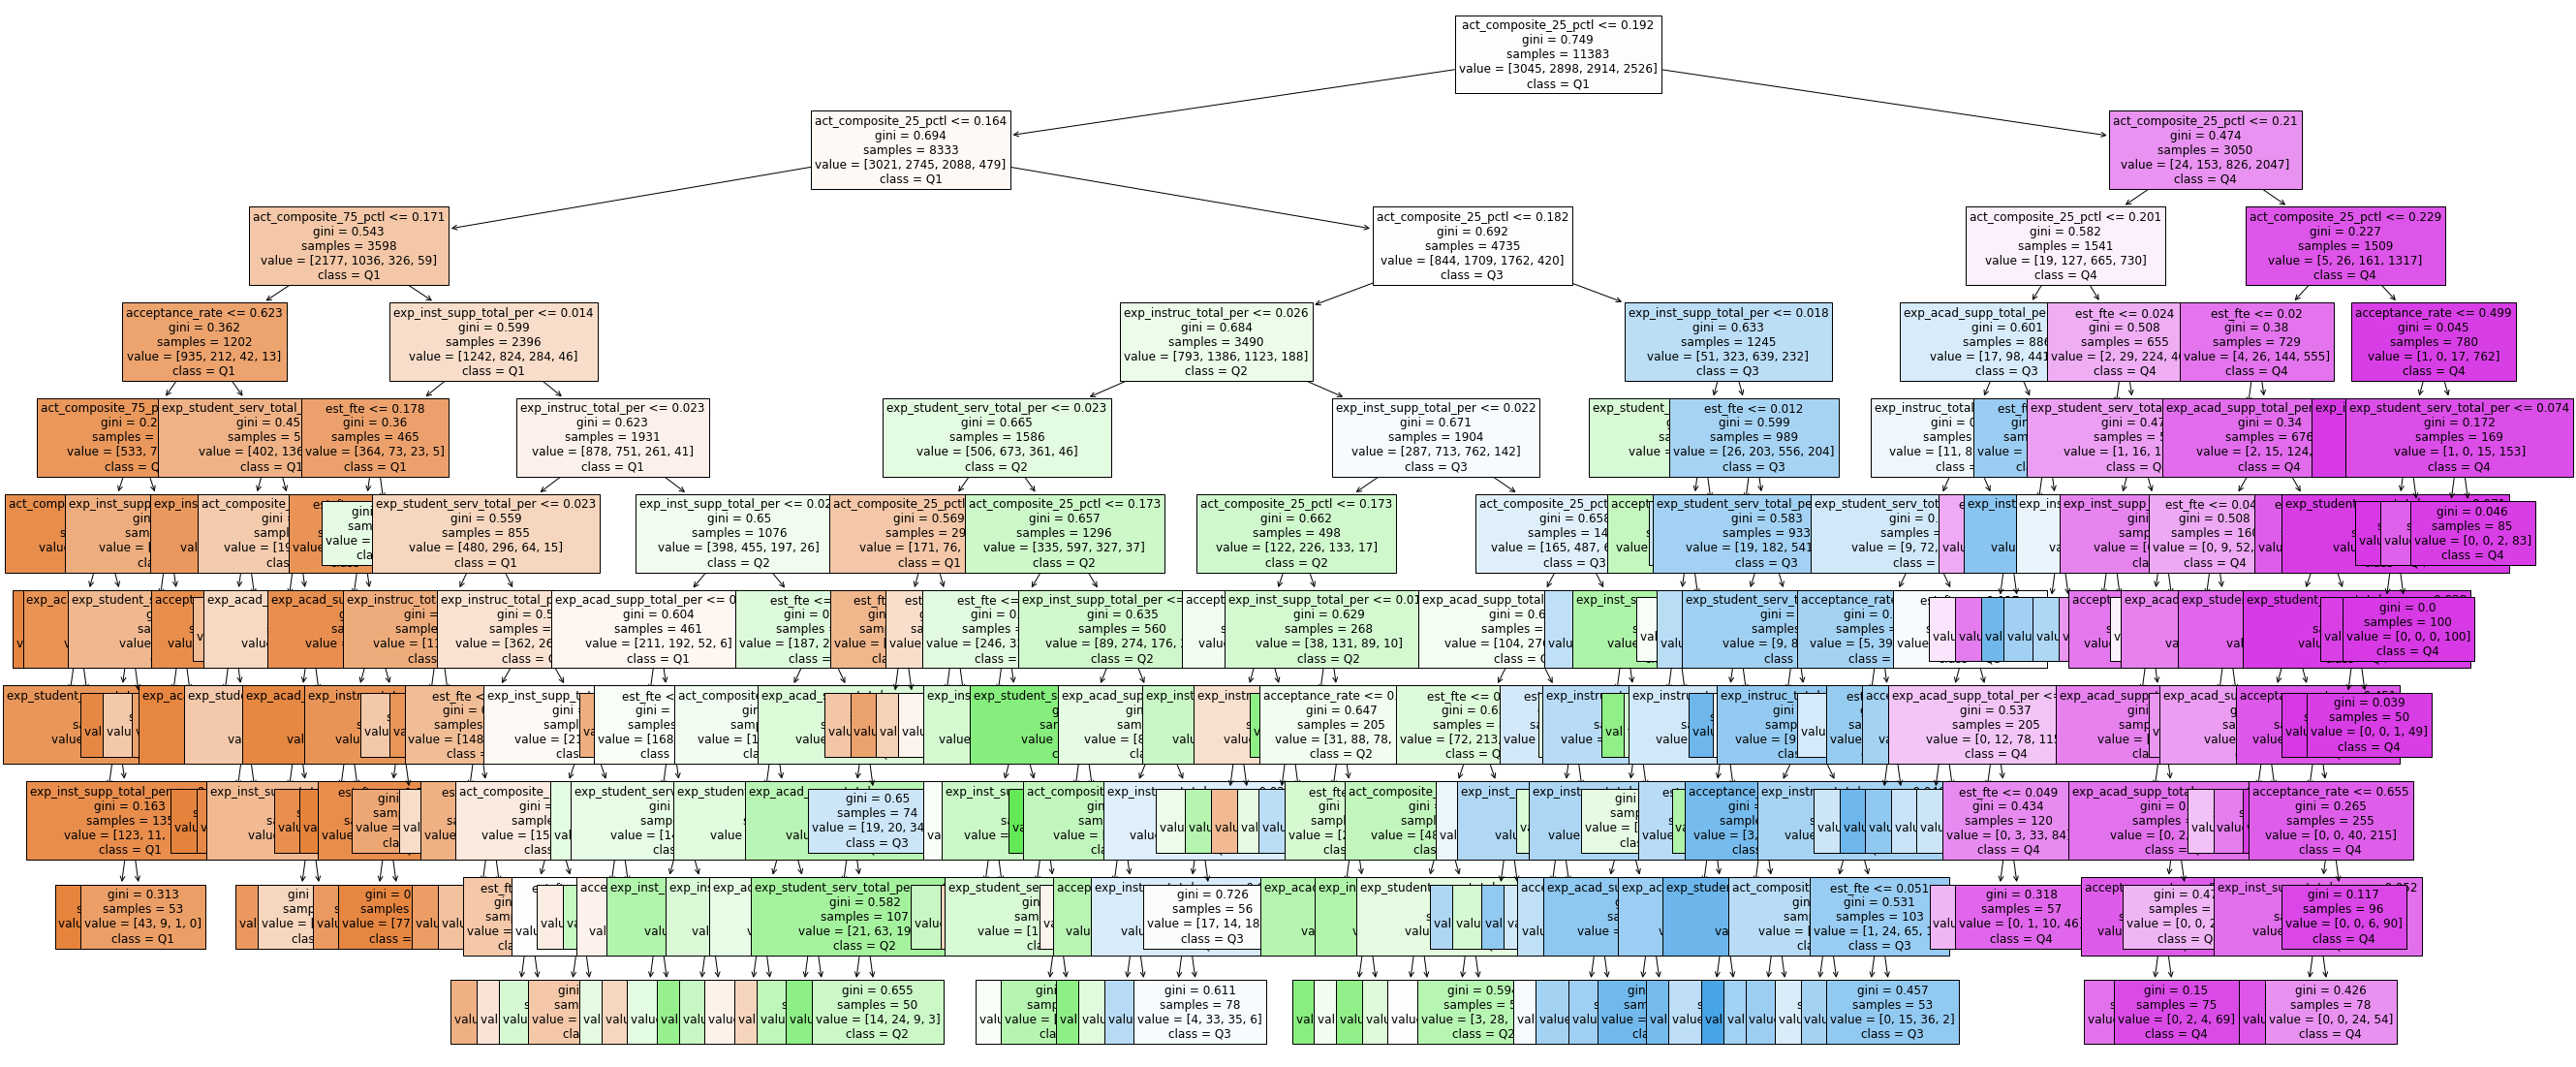

In [45]:
##Plot decision tree
fig = plt.figure(figsize=(45,20))
_ = tree.plot_tree(clf, fontsize=12,
                   feature_names=feature_cols,  
                   class_names=target_names,
                   filled=True)
fig.savefig('Tree4Class.png',dpi=300)


## Dummy Classifier

In [46]:
pipeDum4 = Pipeline([
    ('DummyClassifier', DummyClassifier()) 
])

param_gridDum4 = {
    'DummyClassifier__strategy': ['most_frequent', 'prior', 'stratified', 'uniform'],
}
    
model_gridDum4 = GridSearchCV(pipeDum4, param_gridDum4, cv = 5, n_jobs = 5)
model_gridDum4.fit(X_clean4Trimmed, y_clean4Trimmed)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('DummyClassifier', DummyClassifier())]),
             n_jobs=5,
             param_grid={'DummyClassifier__strategy': ['most_frequent', 'prior',
                                                       'stratified',
                                                       'uniform']})

In [47]:
model_gridDum4.best_params_ ##Best hyperparameters

{'DummyClassifier__strategy': 'most_frequent'}

In [48]:
##model evaluation 
y_predicted = model_gridDum4.predict(X_testTrimmed)
y_predicted[1:20]
print(confusion_matrix(y_test4, y_predicted))
print(classification_report(y_test4, y_predicted))


##print model score
print("Model Score:", model_gridDum4.best_score_)

##Accuracy Score
print("Accuracy Score:",accuracy_score(y_test4, model_gridDum4.predict(X_testTrimmed)))

#Calculate the y_score
y_score = model_gridDum4.predict_proba(X_testTrimmed)

print("AUC Score", roc_auc_score(y_test4, y_score, multi_class='ovr'))

[[499   0   0   0]
 [472   0   0   0]
 [485   0   0   0]
 [500   0   0   0]]
              precision    recall  f1-score   support

           0       0.26      1.00      0.41       499
           1       0.00      0.00      0.00       472
           2       0.00      0.00      0.00       485
           3       0.00      0.00      0.00       500

    accuracy                           0.26      1956
   macro avg       0.06      0.25      0.10      1956
weighted avg       0.07      0.26      0.10      1956

Model Score: 0.26750418527754816
Accuracy Score: 0.2551124744376278
AUC Score 0.5


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1440x1440 with 0 Axes>

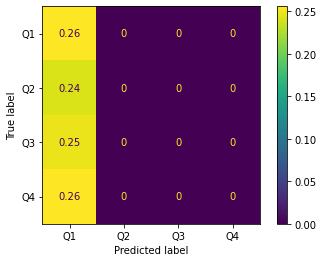

In [49]:
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(model_gridDum4, X_testTrimmed, y_test4, normalize = 'all', display_labels=['Q1','Q2','Q3', 'Q4'])
cmd.figure_.savefig('Dummy_Quart_Fig5F.png',dpi=300)

# Without Selectors
For this analysis I used random but without PCA since the features are already reduced significanly.

## Regression

In [7]:
##Try with full set minus selectivity
X_train = train.loc[:, ~dropped.columns.isin(['unitid', 'Grad_Rates_Two_Classes', 'exp_acad_inst_student_total_per','Grad_Rates_Three_Classes', 'Grad_Rates_Quartiles', 'completion_rate_150pct', 'year', 'cc_basic_2010', 'act_composite_75_pctl', 'act_composite_25_pctl', 'acceptance_rate'])]

X_test = test.loc[:, ~dropped.columns.isin(['unitid', 'Grad_Rates_Two_Classes', 'exp_acad_inst_student_total_per','Grad_Rates_Three_Classes', 'Grad_Rates_Quartiles', 'completion_rate_150pct', 'year', 'cc_basic_2010', 'act_composite_75_pctl', 'act_composite_25_pctl', 'acceptance_rate'])]

y_train = train.completion_rate_150pct

y_test = test.completion_rate_150pct



In [8]:
##anomoly detection and outlier removal
from sklearn.covariance import EllipticEnvelope
envelope1 = EllipticEnvelope(support_fraction=1, contamination=0.03).fit(X_train)

outliers1 = envelope1.predict(X_train)==-1  


X_clean1 = X_train[~outliers1]  
y_clean1 = y_train[~outliers1]

print(f"Num of outliers = {np.sum(outliers1)}")

/opt/conda/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Num of outliers = 353


In [16]:
#create pipe and pqrams
pipe20 = Pipeline([
    ('PCA', PCA()),
    ('LinearRegression', LinearRegression())
])
# Configure the parameters for grid search
param_grid20 = {
    'PCA__n_components': [1, 10, 30, 50, 55],
    'LinearRegression__n_jobs': [1,3,5]
}

# Train the Pipeline with Grid Search 
model_grid20 = GridSearchCV(pipe20, param_grid20, cv = 5, n_jobs = 5)
model_grid20.fit(X_clean1, y_clean1)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('PCA', PCA()),
                                       ('LinearRegression',
                                        LinearRegression())]),
             n_jobs=5,
             param_grid={'LinearRegression__n_jobs': [1, 3, 5],
                         'PCA__n_components': [1, 10, 30, 50, 55]})

In [17]:
model_grid20.best_params_ ##Best hyperparameters

{'LinearRegression__n_jobs': 1, 'PCA__n_components': 55}

In [18]:
##view results print(model_grid.best_params_)
print(model_grid20.best_score_)

0.2857545618109319


In [19]:
## get predictions
y_predicted = model_grid20.predict(X_test)
##explained variance
explained_variance_score(y_test, y_predicted)

0.2684675397803741

In [20]:

##r2 score
r2_score(y_test, y_predicted)




0.2654696748067532

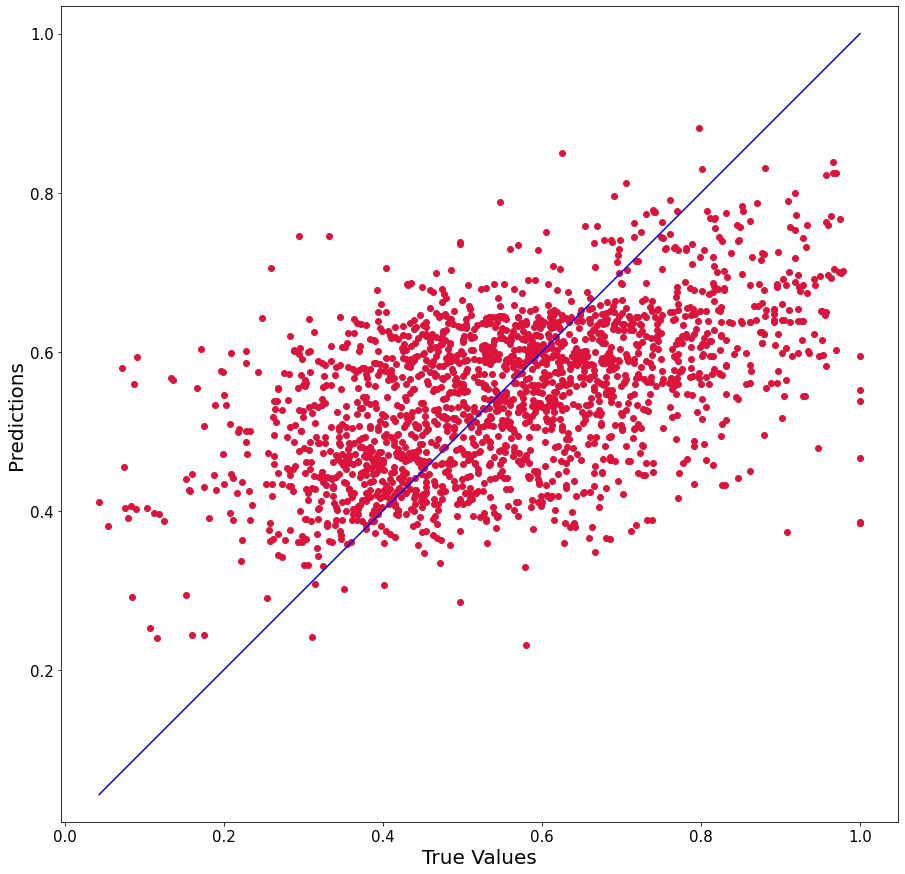

In [21]:
plt.figure(figsize=(15,15))
plt.scatter(y_test, y_predicted, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_predicted), max(y_test))
p2 = min(min(y_predicted), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=20)
plt.ylabel('Predictions', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis('equal')
plt.savefig('RegressionAcutalVsPredicted_No_SelectorsFullSet.png',dpi=300)

In [50]:
##create subset of trimmed minus selectivity
X_train = train[['est_fte', 'exp_instruc_total_per', 'exp_acad_supp_total_per', 'exp_student_serv_total_per', 'exp_inst_supp_total_per']]

X_test = test[['est_fte', 'exp_instruc_total_per', 'exp_acad_supp_total_per', 'exp_student_serv_total_per', 'exp_inst_supp_total_per']]

y_train = train.completion_rate_150pct

y_test = test.completion_rate_150pct

X_train.head(1)

est_fte  exp_instruc_total_per  exp_acad_supp_total_per  \
11618  0.804298               0.092503                 0.049112   

       exp_student_serv_total_per  exp_inst_supp_total_per  
11618                     0.06432                 0.055147

In [51]:
##anomoly detection and outlier removal
from sklearn.covariance import EllipticEnvelope
envelope1 = EllipticEnvelope(support_fraction=1, contamination=0.03).fit(X_train)

outliers1 = envelope1.predict(X_train)==-1  


X_clean1 = X_train[~outliers1]  
y_clean1 = y_train[~outliers1]

print(f"Num of outliers = {np.sum(outliers1)}")

Num of outliers = 353


In [52]:
#create pipe and pqrams
pipe20 = Pipeline([
    ('LinearRegression', LinearRegression())
])
# Configure the parameters for grid search
param_grid20 = {
    'LinearRegression__n_jobs': [1,3,5]
}


In [53]:
# Train the Pipeline with Grid Search 
model_grid20 = GridSearchCV(pipe20, param_grid20, cv = 5, n_jobs = 5)
model_grid20.fit(X_clean1, y_clean1)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('LinearRegression',
                                        LinearRegression())]),
             n_jobs=5, param_grid={'LinearRegression__n_jobs': [1, 3, 5]})

In [54]:
model_grid20.best_params_ ##Best hyperparameters

{'LinearRegression__n_jobs': 1}

In [55]:
##view results print(model_grid.best_params_)
print(model_grid20.best_score_)


0.3391828595864991


In [56]:
## get predictions
y_predicted = model_grid20.predict(X_test)

In [57]:
##explained variance
explained_variance_score(y_test, y_predicted)


-0.861578290250389

In [58]:

##r2 score
r2_score(y_test, y_predicted)



-0.8757157627565033

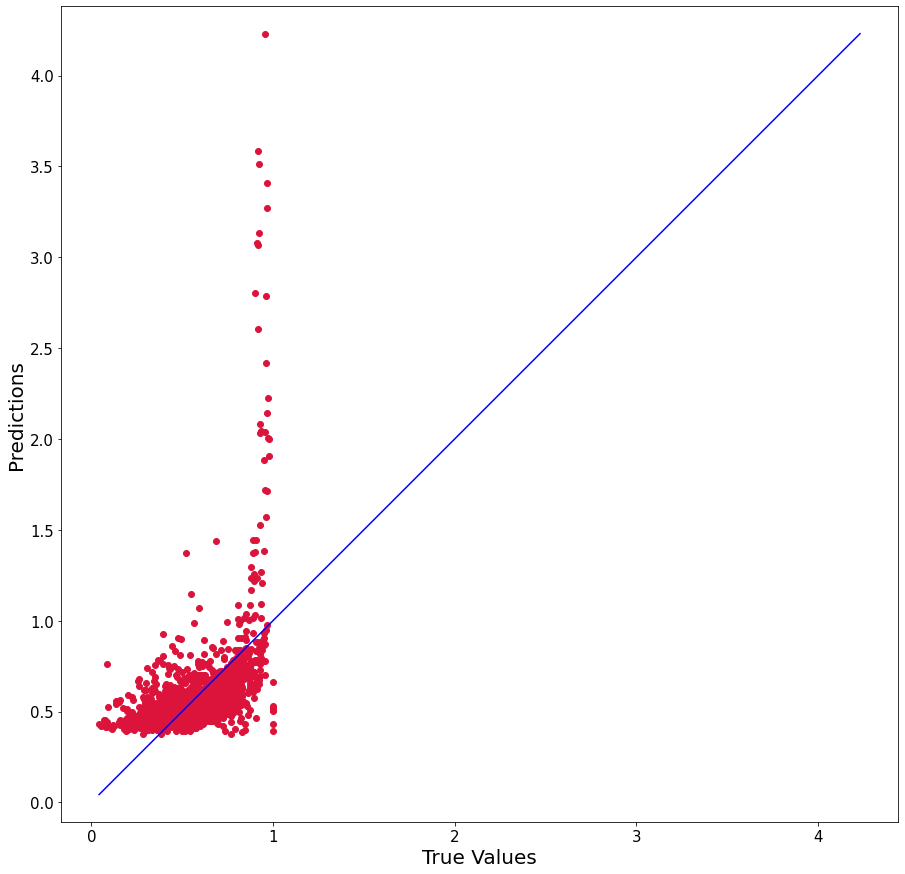

In [54]:
plt.figure(figsize=(15,15))
plt.scatter(y_test, y_predicted, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_predicted), max(y_test))
p2 = min(min(y_predicted), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=20)
plt.ylabel('Predictions', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis('equal')
plt.savefig('RegressionAcutalVsPredicted_No_Selectors.png',dpi=300)

### Low High

In [9]:
##create subset of just desired variables from test and train
X_train = train[['est_fte', 'exp_instruc_total_per', 'exp_acad_supp_total_per', 'exp_student_serv_total_per', 'exp_inst_supp_total_per']]

X_test = test[['est_fte', 'exp_instruc_total_per', 'exp_acad_supp_total_per', 'exp_student_serv_total_per', 'exp_inst_supp_total_per']]

y_train = train.Grad_Rates_Two_Classes

y_test = test.Grad_Rates_Two_Classes

X_train.head(1)

est_fte  exp_instruc_total_per  exp_acad_supp_total_per  \
11618  0.804298               0.092503                 0.049112   

       exp_student_serv_total_per  exp_inst_supp_total_per  
11618                     0.06432                 0.055147

In [10]:
##anomoly detection and outlier removal
from sklearn.covariance import EllipticEnvelope
envelope1 = EllipticEnvelope(support_fraction=1, contamination=0.03).fit(X_train)

outliers1 = envelope1.predict(X_train)==-1  


X_clean1 = X_train[~outliers1]  
y_clean1 = y_train[~outliers1]

print(f"Num of outliers = {np.sum(outliers1)}")

Num of outliers = 353


In [11]:
pipe8 = Pipeline([
    ('RandomForestClassifier', RandomForestClassifier()) 
])

param_grid8 = {
    'RandomForestClassifier__n_estimators': [50, 100, 150],
    'RandomForestClassifier__criterion': ['gini', 'entropy'],
    'RandomForestClassifier__max_depth': [8]
    
}
    
model_grid8 = GridSearchCV(pipe8, param_grid8, cv = 5, n_jobs = 5)
model_grid8.fit(X_clean1, y_clean1)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('RandomForestClassifier',
                                        RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'RandomForestClassifier__criterion': ['gini',
                                                               'entropy'],
                         'RandomForestClassifier__max_depth': [8],
                         'RandomForestClassifier__n_estimators': [50, 100,
                                                                  150]})

In [12]:
model_grid8.best_params_ ##Best hyperparameters

{'RandomForestClassifier__criterion': 'gini',
 'RandomForestClassifier__max_depth': 8,
 'RandomForestClassifier__n_estimators': 100}

In [13]:
##model evaluation 
y_predicted = model_grid8.predict(X_test)
y_predicted[1:20]
print(confusion_matrix(y_test, y_predicted))
print(classification_report(y_test, y_predicted))

[[762 195]
 [241 758]]
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       957
           1       0.80      0.76      0.78       999

    accuracy                           0.78      1956
   macro avg       0.78      0.78      0.78      1956
weighted avg       0.78      0.78      0.78      1956



In [14]:
##print model score
print(model_grid8.best_score_)

0.7620134638970123


In [15]:
##Accuracy Score
accuracy_score(y_test, model_grid8.predict(X_test))

0.7770961145194274

In [16]:
##AUC
##get predictions
y_predicted = model_grid8.predict(X_test)

##Auc Score
fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
auc(fpr, tpr)

0.7774985016364326

<Figure size 1440x1440 with 0 Axes>

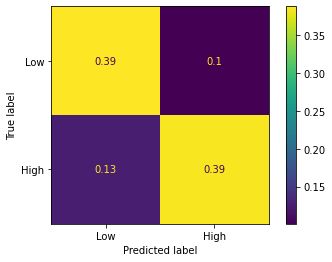

In [93]:
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(model_grid8, X_test, y_test, normalize = 'all', display_labels=['Low', 'High'])
cmd.figure_.savefig('Random_LH_Fig7F.png',dpi=300)


## Decision Tree

In [68]:
clf = DecisionTreeClassifier(max_depth = 4, random_state=21)
model = clf.fit(X_clean1, y_clean1)

In [69]:
## Accuracy
pred = clf.predict(X_test)
acc = accuracy_score(pred, y_test)
acc

0.7305725971370143

In [70]:
#create feature col
feature_cols = []
for i in X_clean1.columns.values:
    feature_cols.append(i)
type(feature_cols)
target_names=['Low', 'High']
feature_cols
X = X_clean1
y = y_clean1

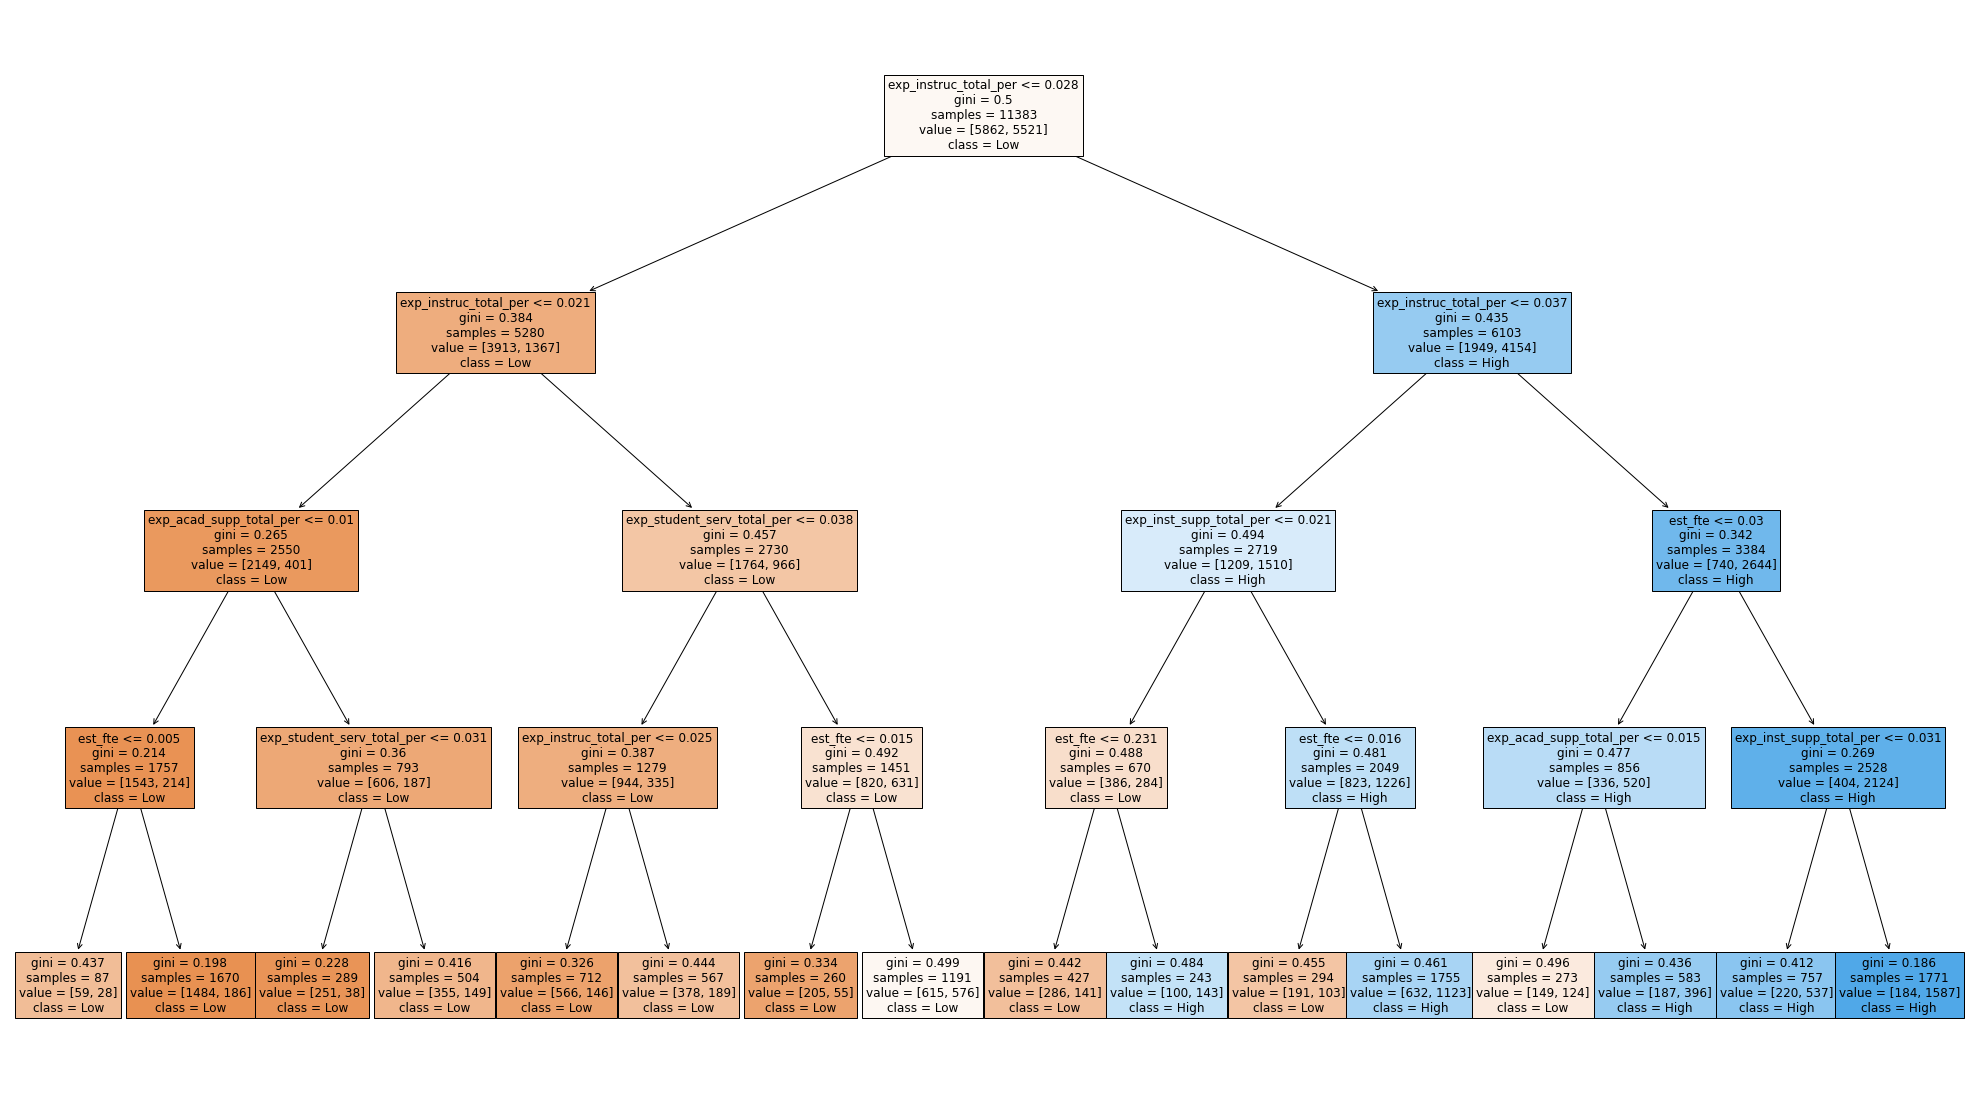

In [71]:
##Plot decision tree
fig = plt.figure(figsize=(35,20))
_ = tree.plot_tree(clf, fontsize=12,
                   feature_names=feature_cols,  
                   class_names=target_names,
                   filled=True)
fig.savefig('Tree2ClassNoSelectivityF.png',dpi=300)



## Dummy Classifier

In [17]:
DumPipe = Pipeline([
    ('DummyClassifier', DummyClassifier()) 
])

Dum_param_grid = {
    'DummyClassifier__strategy': ['most_frequent', 'prior', 'stratified', 'uniform'],
}
    
dum_model = GridSearchCV(DumPipe, Dum_param_grid, cv = 5, n_jobs = 5)
dum_model.fit(X_clean1, y_clean1)

print("Best Hyperparameters:",dum_model.best_params_) ##Best hyperparameters

Best Hyperparameters: {'DummyClassifier__strategy': 'most_frequent'}


In [18]:
##model evaluation 
y_predicted = dum_model.predict(X_test)
y_predicted[1:20]
print(confusion_matrix(y_test, y_predicted))
print(classification_report(y_test, y_predicted))


##print model score
print("Model Score:", dum_model.best_score_)

##Accuracy Score
print("Accuracy Score:",accuracy_score(y_test, dum_model.predict(X_test)))

##AUC
##get predictions
y_predicted = dum_model.predict(X_test)

##Auc Score
fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
print("AUC Score:",auc(fpr, tpr))

[[957   0]
 [999   0]]
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       957
           1       0.00      0.00      0.00       999

    accuracy                           0.49      1956
   macro avg       0.24      0.50      0.33      1956
weighted avg       0.24      0.49      0.32      1956

Model Score: 0.5149784696510454
Accuracy Score: 0.4892638036809816
AUC Score: 0.5


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1440x1440 with 0 Axes>

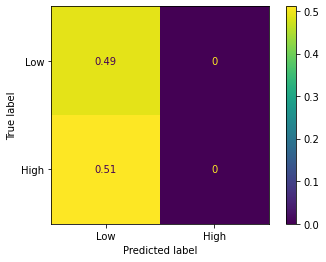

In [19]:
##Create confusion for dummy
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(dum_model, X_test, y_test, normalize = 'all', display_labels=['Low', 'High'])
cmd.figure_.savefig('Dummy_LH_Fig7F.png',dpi=300)

### Low Medium High

In [20]:
##create subset of just desired variables from test and train
X_train = train[['est_fte', 'exp_instruc_total_per', 'exp_acad_supp_total_per', 'exp_student_serv_total_per', 'exp_inst_supp_total_per']]

X_test = test[['est_fte', 'exp_instruc_total_per', 'exp_acad_supp_total_per', 'exp_student_serv_total_per', 'exp_inst_supp_total_per']]

y_train = train.Grad_Rates_Three_Classes

y_test = test.Grad_Rates_Three_Classes

X_train.head(1)

est_fte  exp_instruc_total_per  exp_acad_supp_total_per  \
11618  0.804298               0.092503                 0.049112   

       exp_student_serv_total_per  exp_inst_supp_total_per  
11618                     0.06432                 0.055147

In [21]:
##anomoly detection and outlier removal
from sklearn.covariance import EllipticEnvelope
envelope1 = EllipticEnvelope(support_fraction=1, contamination=0.03).fit(X_train)

outliers1 = envelope1.predict(X_train)==-1  


X_clean1 = X_train[~outliers1]  
y_clean1 = y_train[~outliers1]

print(f"Num of outliers = {np.sum(outliers1)}")

Num of outliers = 353


In [74]:
pipe9 = Pipeline([
    ('RandomForestClassifier', RandomForestClassifier()) 
])

param_grid9 = {
    'RandomForestClassifier__n_estimators': [50, 100, 150],
    'RandomForestClassifier__criterion': ['gini', 'entropy'],
    'RandomForestClassifier__max_depth': [8]
    
}
    
model_grid9 = GridSearchCV(pipe9, param_grid9, cv = 5, n_jobs = 5)
model_grid9.fit(X_clean1, y_clean1)




GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('RandomForestClassifier',
                                        RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'RandomForestClassifier__criterion': ['gini',
                                                               'entropy'],
                         'RandomForestClassifier__max_depth': [8],
                         'RandomForestClassifier__n_estimators': [50, 100,
                                                                  150]})

In [75]:
model_grid9.best_params_ ##Best hyperparameters

{'RandomForestClassifier__criterion': 'entropy',
 'RandomForestClassifier__max_depth': 8,
 'RandomForestClassifier__n_estimators': 100}

In [76]:
##model evaluation 
y_predicted = model_grid9.predict(X_test)
y_predicted[1:20]
print(confusion_matrix(y_test, y_predicted))
print(classification_report(y_test, y_predicted))

[[459 137  59]
 [165 332 151]
 [ 49 125 479]]
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       655
           1       0.56      0.51      0.53       648
           2       0.70      0.73      0.71       653

    accuracy                           0.65      1956
   macro avg       0.65      0.65      0.65      1956
weighted avg       0.65      0.65      0.65      1956



In [77]:
##print model score
print(model_grid9.best_score_)

0.6210124859815391


In [78]:
##Accuracy Score
accuracy_score(y_test, model_grid9.predict(X_test))

0.6492842535787321

In [79]:
#roc_auc_score(y_test, model_grid3.predict_proba(X_test)[:,1])
#Calculate the y_score
y_score = model_grid9.predict_proba(X_test)

##get auc score
roc_auc_score(y_test, y_score, multi_class='ovr')

0.8173649951180163

<Figure size 1440x1440 with 0 Axes>

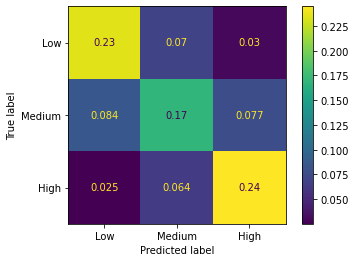

In [80]:
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(model_grid9, X_test, y_test, normalize = 'all', display_labels=['Low', 'Medium', 'High'])
cmd.figure_.savefig('Random_LMH_Fig8F.png',dpi=300)


## Decision Tree

In [81]:
##Create tree
clf = DecisionTreeClassifier(max_depth = 4, random_state=21)
model = clf.fit(X_clean1, y_clean1)

In [82]:
## Accuracy
pred = clf.predict(X_test)
acc = accuracy_score(pred, y_test)
acc

0.5547034764826176

In [83]:
#create feature col
feature_cols = []
for i in X_clean1.columns.values:
    feature_cols.append(i)
type(feature_cols)
target_names=['Low', 'Medium', 'High']
feature_cols
X = X_clean1
y = y_clean1

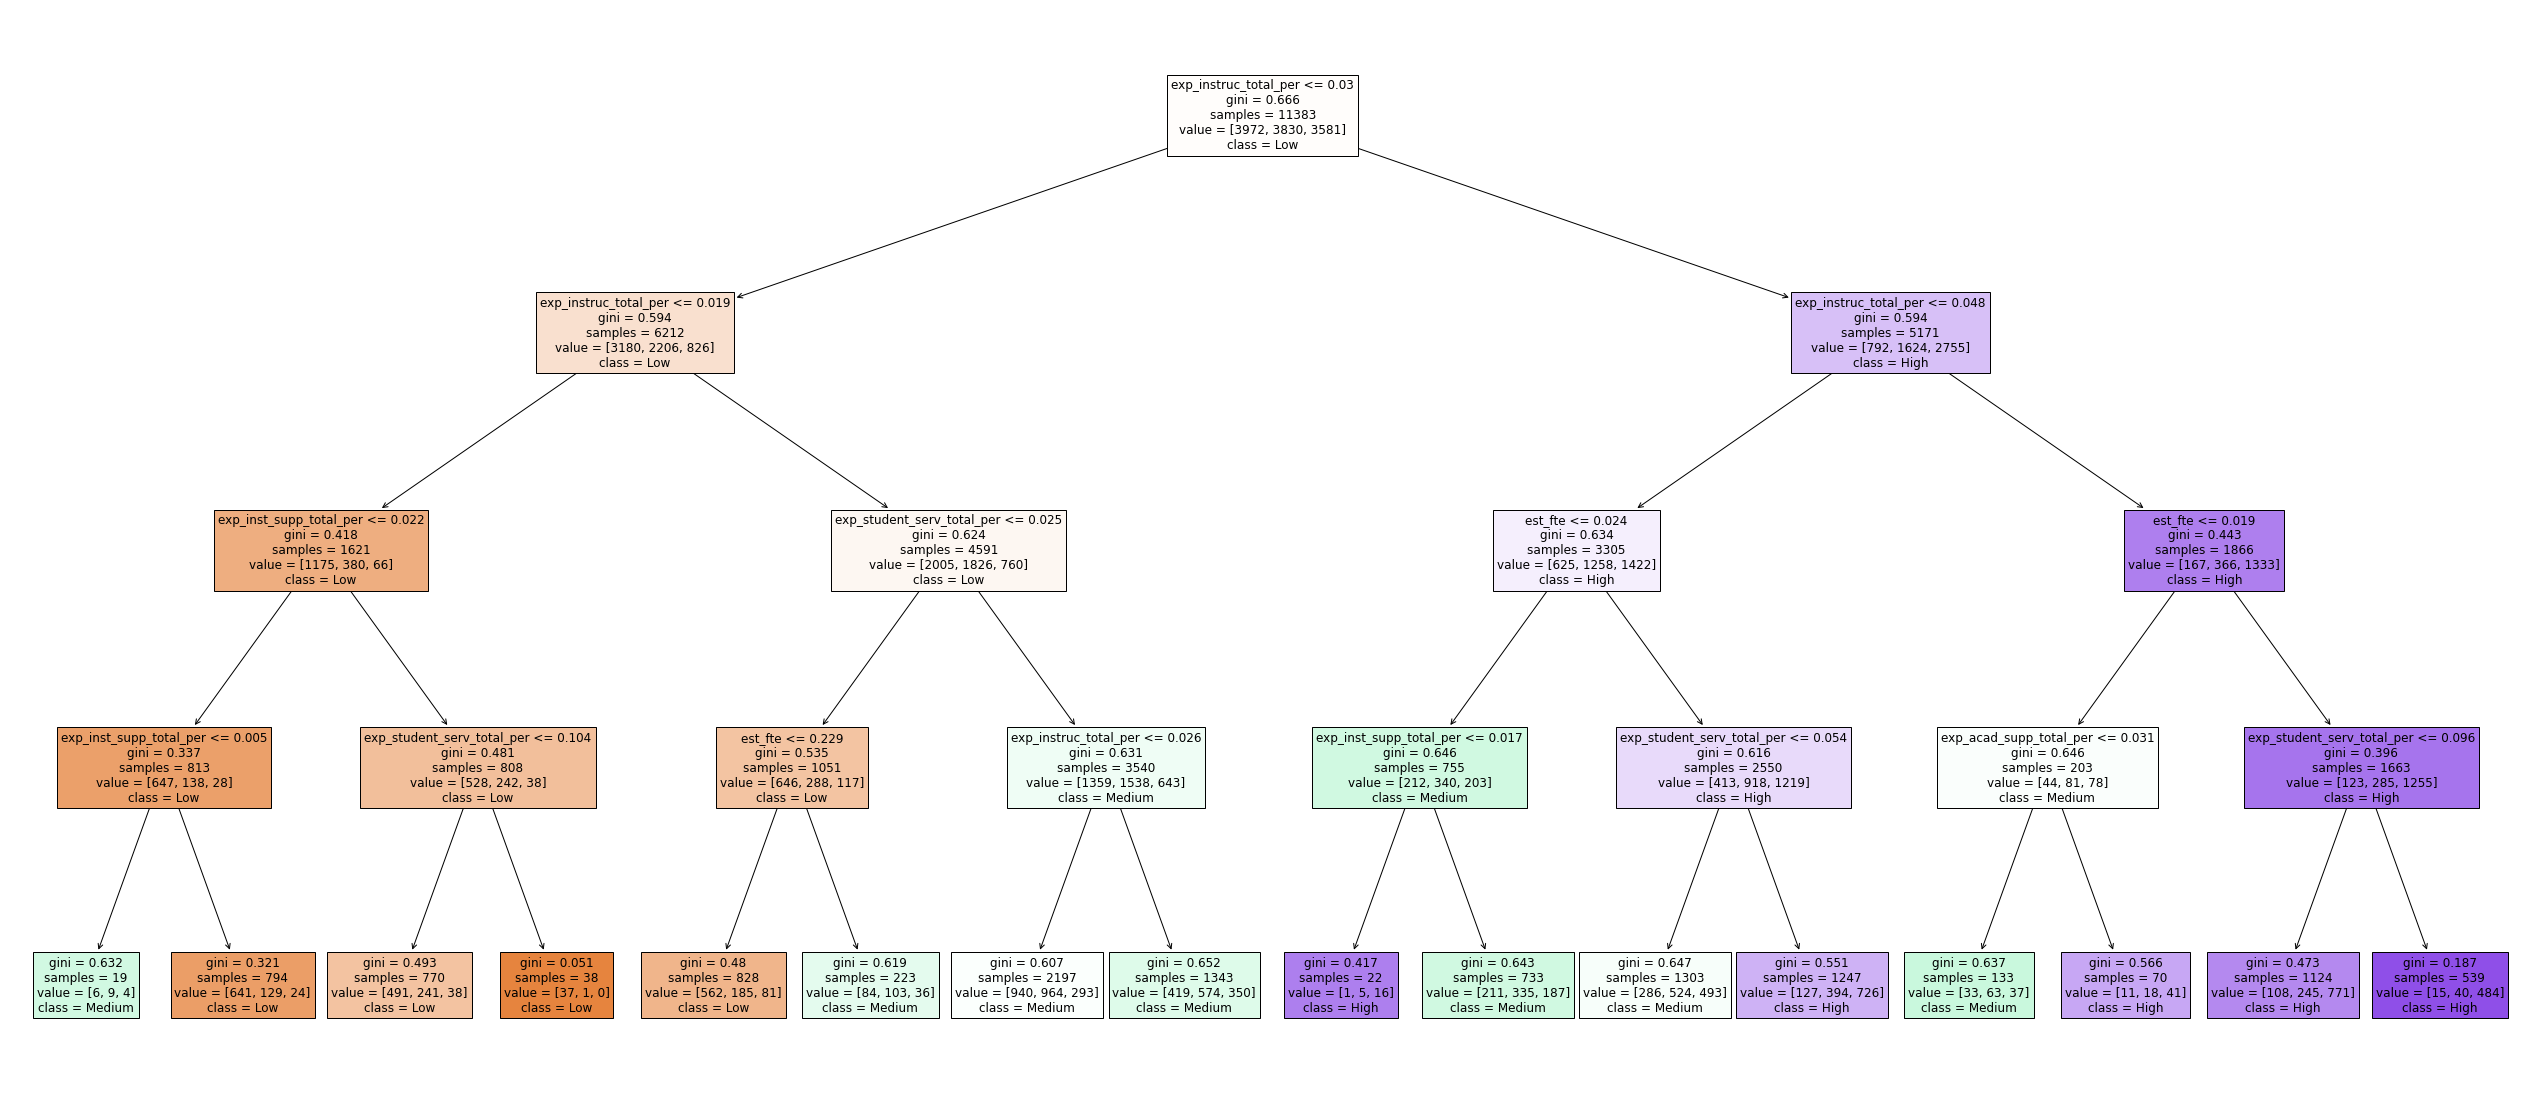

In [84]:
##Plot decision tree
fig = plt.figure(figsize=(45,20))
_ = tree.plot_tree(clf, fontsize=12,
                   feature_names=feature_cols,  
                   class_names=target_names,
                   filled=True)
fig.savefig('Tree3ClassNoSelectivityF.png',dpi=300)




## Dummy Classifier

In [22]:
DumPipe = Pipeline([
    ('DummyClassifier', DummyClassifier()) 
])

Dum_param_grid = {
    'DummyClassifier__strategy': ['most_frequent', 'prior', 'stratified', 'uniform'],
}
    
dum_model = GridSearchCV(DumPipe, Dum_param_grid, cv = 5, n_jobs = 5)
dum_model.fit(X_clean1, y_clean1)

print("Best Hyperparameters:",dum_model.best_params_) ##Best hyperparameters

Best Hyperparameters: {'DummyClassifier__strategy': 'most_frequent'}


In [23]:
##model evaluation 
y_predicted = dum_model.predict(X_test)
y_predicted[1:20]
print(confusion_matrix(y_test, y_predicted))
print(classification_report(y_test, y_predicted))


##print model score
print("Model Score:", dum_model.best_score_)

##Accuracy Score
print("Accuracy Score:",accuracy_score(y_test, dum_model.predict(X_test)))

#Calculate the y_score
y_score = dum_model.predict_proba(X_test)

print("AUC Score", roc_auc_score(y_test, y_score, multi_class='ovr'))

[[655   0   0]
 [648   0   0]
 [653   0   0]]
              precision    recall  f1-score   support

           0       0.33      1.00      0.50       655
           1       0.00      0.00      0.00       648
           2       0.00      0.00      0.00       653

    accuracy                           0.33      1956
   macro avg       0.11      0.33      0.17      1956
weighted avg       0.11      0.33      0.17      1956

Model Score: 0.3489413891339466
Accuracy Score: 0.33486707566462165
AUC Score 0.5


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1440x1440 with 0 Axes>

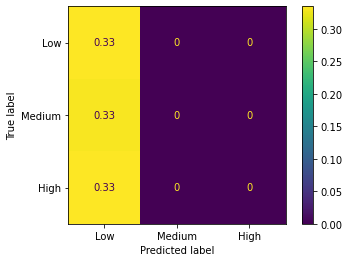

In [24]:
##Create confusion for dummy
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(dum_model, X_test, y_test, normalize = 'all', display_labels=['Low', 'Medium', 'High'])
cmd.figure_.savefig('Dummy_LMH_Fig8F.png',dpi=300)

### Quartiles

In [25]:
##create subset of just desired variables from test and train
X_train = train[['est_fte', 'exp_instruc_total_per', 'exp_acad_supp_total_per', 'exp_student_serv_total_per', 'exp_inst_supp_total_per']]

X_test = test[['est_fte', 'exp_instruc_total_per', 'exp_acad_supp_total_per', 'exp_student_serv_total_per', 'exp_inst_supp_total_per']]

y_train = train.Grad_Rates_Quartiles

y_test = test.Grad_Rates_Quartiles

X_train.head(1)

est_fte  exp_instruc_total_per  exp_acad_supp_total_per  \
11618  0.804298               0.092503                 0.049112   

       exp_student_serv_total_per  exp_inst_supp_total_per  
11618                     0.06432                 0.055147

In [26]:
##anomoly detection and outlier removal
from sklearn.covariance import EllipticEnvelope
envelope1 = EllipticEnvelope(support_fraction=1, contamination=0.03).fit(X_train)

outliers1 = envelope1.predict(X_train)==-1  


X_clean1 = X_train[~outliers1]  
y_clean1 = y_train[~outliers1]

print(f"Num of outliers = {np.sum(outliers1)}")

Num of outliers = 353


In [96]:
pipe10 = Pipeline([
    ('RandomForestClassifier', RandomForestClassifier()) 
])

param_grid10 = {
    'RandomForestClassifier__n_estimators': [50, 100, 150],
    'RandomForestClassifier__criterion': ['gini', 'entropy'],
    'RandomForestClassifier__max_depth': [8]
    
}
    
model_grid10 = GridSearchCV(pipe10, param_grid10, cv = 5, n_jobs = 5)
model_grid10.fit(X_clean1, y_clean1)





GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('RandomForestClassifier',
                                        RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'RandomForestClassifier__criterion': ['gini',
                                                               'entropy'],
                         'RandomForestClassifier__max_depth': [8],
                         'RandomForestClassifier__n_estimators': [50, 100,
                                                                  150]})

In [97]:
model_grid10.best_params_ ##Best hyperparameters

{'RandomForestClassifier__criterion': 'entropy',
 'RandomForestClassifier__max_depth': 8,
 'RandomForestClassifier__n_estimators': 150}

In [98]:
##model evaluation 
y_predicted = model_grid10.predict(X_test)
y_predicted[1:20]
print(confusion_matrix(y_test, y_predicted))
print(classification_report(y_test, y_predicted))

[[313 101  60  25]
 [129 195 107  41]
 [ 68 108 209 100]
 [ 19  27 116 338]]
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       499
           1       0.45      0.41      0.43       472
           2       0.42      0.43      0.43       485
           3       0.67      0.68      0.67       500

    accuracy                           0.54      1956
   macro avg       0.53      0.54      0.54      1956
weighted avg       0.54      0.54      0.54      1956



In [99]:
##print model score
print(model_grid10.best_score_)

0.5306160481563553


In [100]:
##Accuracy Score
accuracy_score(y_test, model_grid10.predict(X_test))

0.5393660531697342

In [101]:
#roc_auc_score(y_test, model_grid3.predict_proba(X_test)[:,1])
#Calculate the y_score
y_score = model_grid10.predict_proba(X_test)

##get auc score
roc_auc_score(y_test, y_score, multi_class='ovr')

0.808196948996172

<Figure size 1440x1440 with 0 Axes>

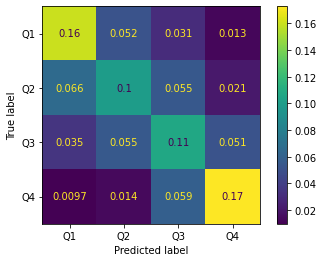

In [102]:
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(model_grid10, X_test, y_test, normalize = 'all', display_labels=['Q1', 'Q2', 'Q3', 'Q4'])
cmd.figure_.savefig('Random_Quart_Fig9F.png',dpi=300)



## Decision Tree

In [103]:
##Create tree
clf = DecisionTreeClassifier(max_depth = 4, random_state=21)
model = clf.fit(X_clean1, y_clean1)

In [104]:
## Accuracy
pred = clf.predict(X_test)
acc = accuracy_score(pred, y_test)
acc

0.48517382413087934

In [105]:
#create feature col
feature_cols = []
for i in X_clean1.columns.values:
    feature_cols.append(i)
type(feature_cols)
target_names=['Q1', 'Q2', 'Q3', 'Q4']
feature_cols
X = X_clean1
y = y_clean1

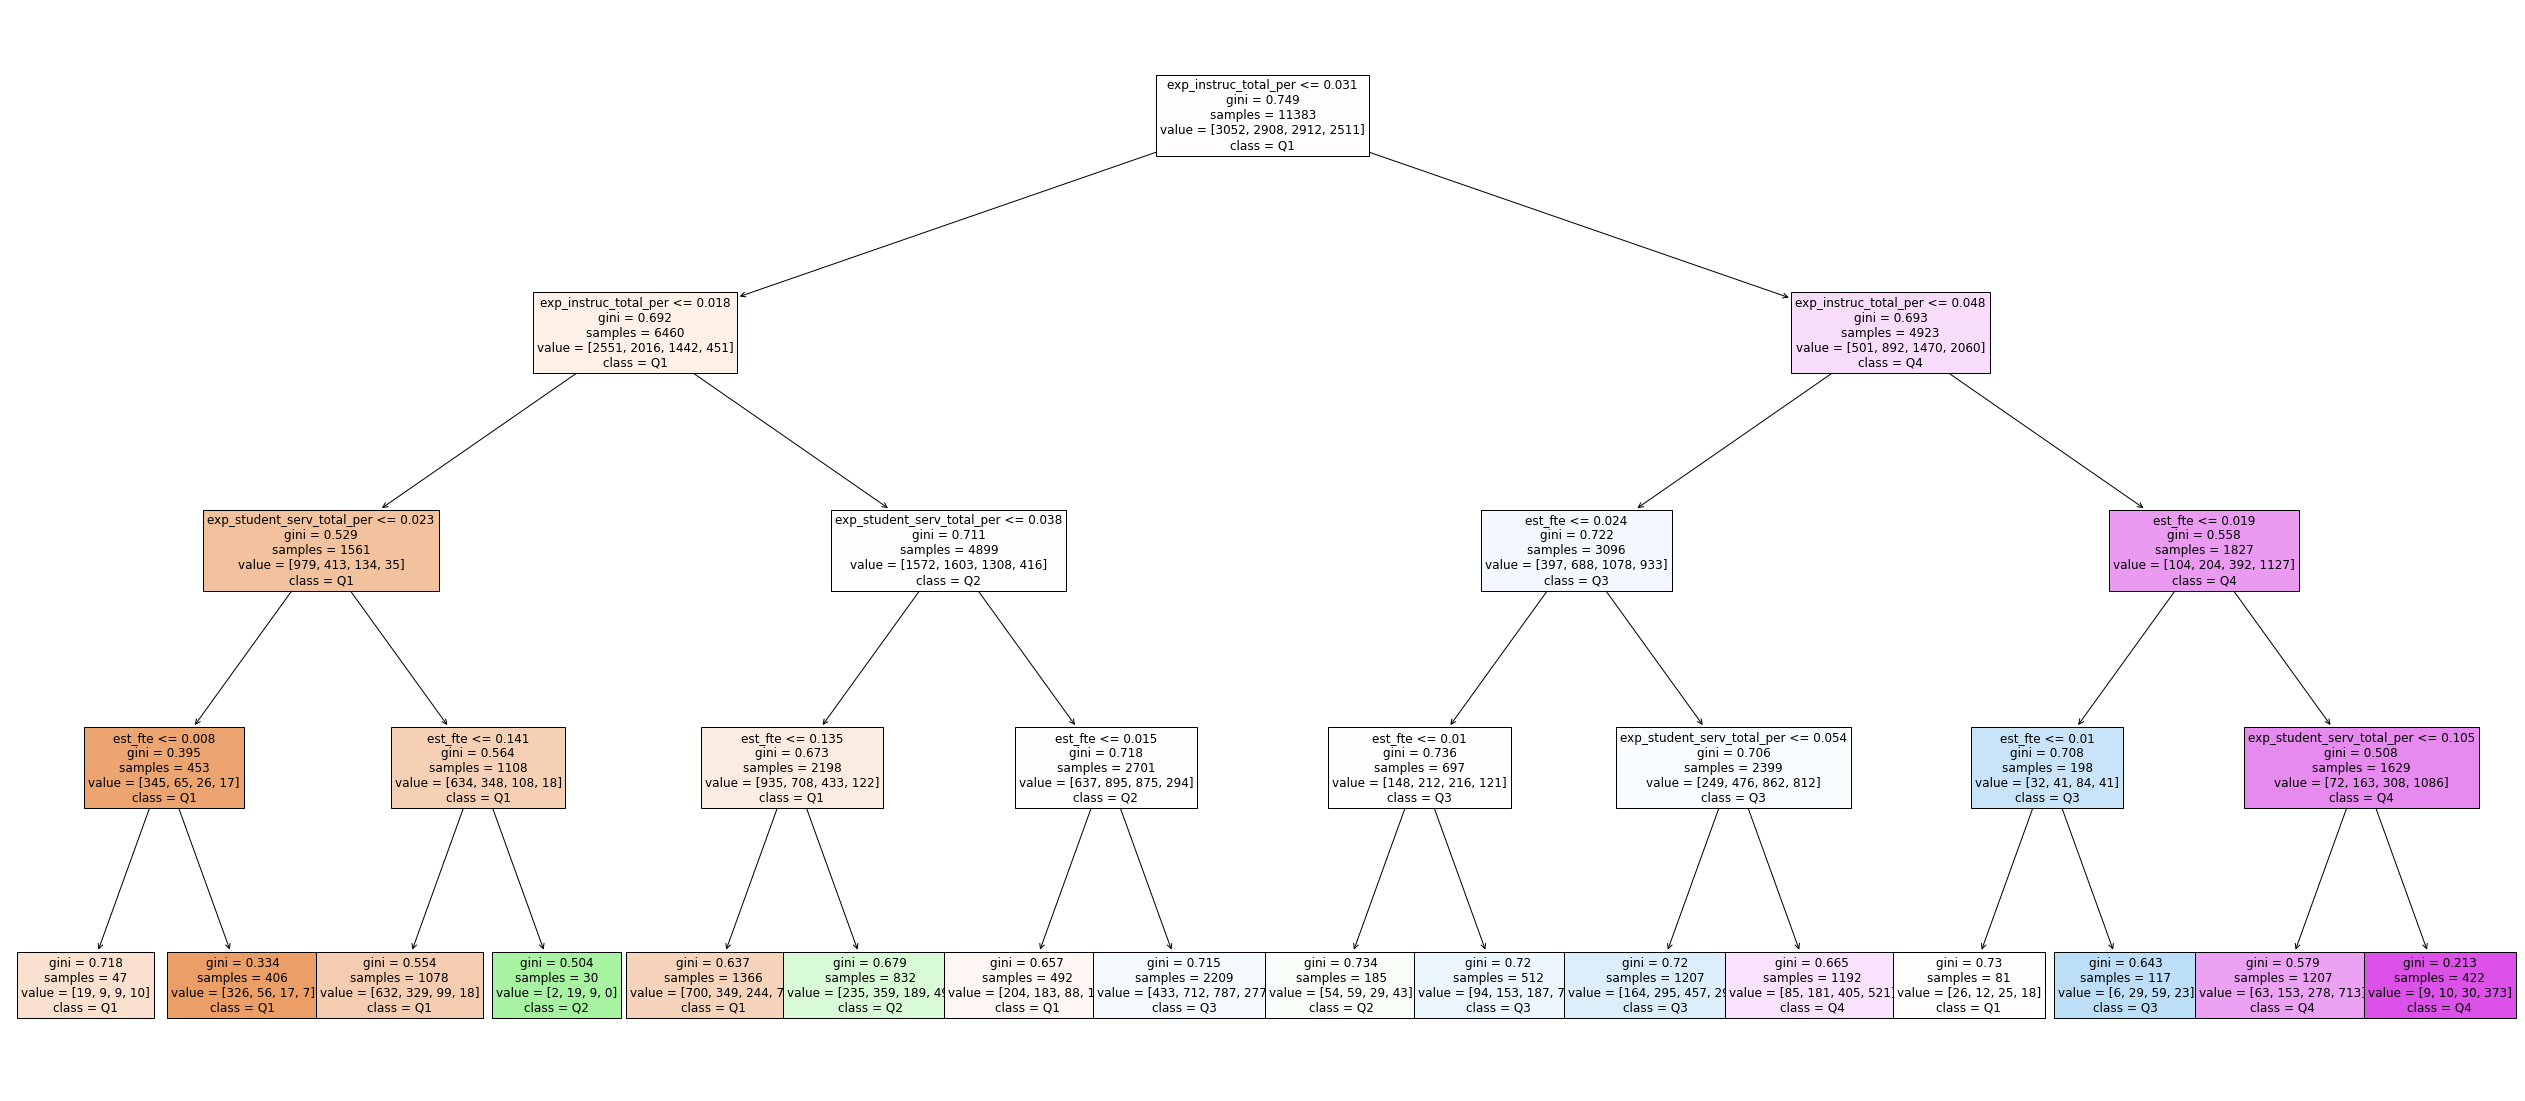

In [106]:
##Plot decision tree
fig = plt.figure(figsize=(45,20))
_ = tree.plot_tree(clf, fontsize=12,
                   feature_names=feature_cols,  
                   class_names=target_names,
                   filled=True)
fig.savefig('Tree4ClassNoSelectivityF.png',dpi=300)


## Dummy Classifier

In [27]:
DumPipe = Pipeline([
    ('DummyClassifier', DummyClassifier()) 
])

Dum_param_grid = {
    'DummyClassifier__strategy': ['most_frequent', 'prior', 'stratified', 'uniform'],
}
    
dum_model = GridSearchCV(DumPipe, Dum_param_grid, cv = 5, n_jobs = 5)
dum_model.fit(X_clean1, y_clean1)

print("Best Hyperparameters:",dum_model.best_params_) ##Best hyperparameters

Best Hyperparameters: {'DummyClassifier__strategy': 'most_frequent'}


In [28]:
##model evaluation 
y_predicted = dum_model.predict(X_test)
y_predicted[1:20]
print(confusion_matrix(y_test, y_predicted))
print(classification_report(y_test, y_predicted))


##print model score
print("Model Score:", dum_model.best_score_)

##Accuracy Score
print("Accuracy Score:",accuracy_score(y_test, dum_model.predict(X_test)))

#Calculate the y_score
y_score = dum_model.predict_proba(X_test)

print("AUC Score", roc_auc_score(y_test, y_score, multi_class='ovr'))

[[499   0   0   0]
 [472   0   0   0]
 [485   0   0   0]
 [500   0   0   0]]
              precision    recall  f1-score   support

           0       0.26      1.00      0.41       499
           1       0.00      0.00      0.00       472
           2       0.00      0.00      0.00       485
           3       0.00      0.00      0.00       500

    accuracy                           0.26      1956
   macro avg       0.06      0.25      0.10      1956
weighted avg       0.07      0.26      0.10      1956

Model Score: 0.2681191065541948
Accuracy Score: 0.2551124744376278
AUC Score 0.5


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1440x1440 with 0 Axes>

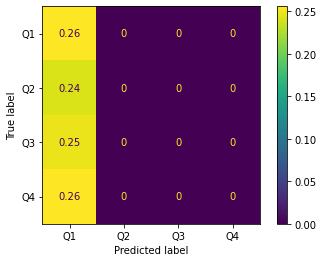

In [29]:
##Create confusion for dummy
plt.figure(figsize=(20,20))
cmd = ConfusionMatrixDisplay.from_estimator(dum_model, X_test, y_test, normalize = 'all', display_labels=['Q1', 'Q2', 'Q3', 'Q4'])
cmd.figure_.savefig('Dummy_Quart_Fig9F.png',dpi=300)